__Overview__:

We start with the preprocessed data on US regional transit lines, containing fields of general description, numerical summary data, and monthly time series data on four different values: unlinked passenger trips (UPT), vehicle revenue miles (VRM), vehicle revenue hours (VRH), and vehicles operated in annual maximum service (VOMS). This consists of 24 out of the 2,237 original records, and 1,028 fields (all 1,026 original fields, plus 2 that were created to improve analysis). Although several changes were considered in the preprocessing step, none were actually made for various reasons, although one will be made in this step.

The purpose of this step is to model and predict the future UPT and profitability of each line.

Goals for this step:

 - Determine the appropriate time series models for each line.
 - Forecast the UPT of each line over several years.
 - Determine if any of the lines will be regularly profitable in the future.

In [2]:
# Import all necessary packages.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from sb_utils import save_file

__Objective__: Load the data.

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Import and display the preprocessed transit data.
# Raw data source: https://www.transit.dot.gov/ntd/data-product/monthly-module-raw-data-release
# Glossary of field names and values: https://www.transit.dot.gov/ntd/national-transit-database-ntd-glossary

transit_data = pd.read_csv('transit_data_preprocessed.csv')
transit_data

5 digit NTD ID 4 digit NTD ID  \
0            10053           1053   
1            20169           2169   
2            20175           2175   
3            20217           2217   
4            30006           3006   
5            40009           4009   
6            40046           4046   
7            40058           4058   
8            40108           4108   
9            41105       4R04-020   
10           50039         5039.0   
11           50149         5149.0   
12           50157         5157.0   
13           50169         5169.0   
14           50199         5199.0   
15           50204         5204.0   
16           60059         6059.0   
17           60102         6102.0   
18           60130         6130.0   
19           70044            NaN   
20           70049         7049.0   
21           80012         8012.0   
22           90032         9032.0   
23           90140         9140.0   

                                               Agency Modes TOS  Active  \
0                   Cape Ann Transportation Authority    DR  PT  Active   
1                            Trans-Bridge Lines, Inc.    CB  DO  Active   
2                  Private Transportation Corporation    MB  PT  Active   
3                                Hampton Jitney, Inc.    CB  DO  Active   
4                    Greater Richmond Transit Company    MB  DO  Active   
5                                City of Fayetteville    MB  DO  Active   
6                                    Sarasota County     DR  PT  Active   
7                                       City of Rome     DR  DO  Active   
8   Research Triangle Regional Public Transportati...    MB  DO  Active   
9               Audubon Area Community Services, Inc.    DR  DO  Active   
10         Saginaw Transit Authority Regional Service    DR  DO  Active   
11               Michiana Area Council of Governments    MB  PT  Active   
12           Butler County Regional Transit Authority    DR  DO  Active   
13                                Miami County, Ohio     DR  PT  Active   
14                      Delaware County Transit Board    DR  DO  Active   
15               Jackson County Mass Transit District    MB  DO  Active   
16                            Brazos Transit District    DR  DO  Active   
17                     Concho Valley Transit District    MB  DO  Active   
18                  Alamo Area Council of Governments    DR  DO  Active   
19                               University of Kansas    MB  PT  Active   
20                                 River Bend Transit    DR  DO  Active   
21                       Great Falls Transit District    DR  DO  Active   
22         City of Phoenix Public Transit Department     MB  PT  Active   
23                                    City of Peoria     DR  DO  Active   

    Reporter Type                                 Organization Type   \
0   Full Reporter  Independent Public Agency or Authority of Tran...   
1   Full Reporter                     Private-For-Profit Corporation   
2   Full Reporter                     Private-For-Profit Corporation   
3   Full Reporter                     Private-For-Profit Corporation   
4   Full Reporter  Other Publicly-Owned or Privately Chartered Co...   
5   Full Reporter  City, County or Local Government Unit or Depar...   
6   Full Reporter  City, County or Local Government Unit or Depar...   
7   Full Reporter  City, County or Local Government Unit or Depar...   
8   Full Reporter  Independent Public Agency or Authority of Tran...   
9   Full Reporter                     Private-Non-Profit Corporation   
10  Full Reporter  Independent Public Agency or Authority of Tran...   
11  Full Reporter                  MPO, COG or Other Planning Agency   
12  Full Reporter  Independent Public Agency or Authority of Tran...   
13  Full Reporter  City, County or Local Government Unit or Depar...   
14  Full Reporter  Independent Public Agency or Authority of Tran...   
15  Full Reporter  Independent Public Agency or Au

In [5]:
transit_data.describe()

5 digit NTD ID         UZA  UZA Area SQ Miles  UZA Population  \
count       24.000000   24.000000          24.000000    2.400000e+01   
mean     49309.625000  152.166667         773.875000    3.141238e+06   
std      21212.673187  156.101045        1128.738477    5.996958e+06   
min      10053.000000    1.000000          30.000000    6.085100e+04   
25%      40036.750000   22.500000          65.500000    1.179448e+05   
50%      50153.000000   87.000000         262.500000    4.954310e+05   
75%      60109.000000  268.500000         877.750000    2.225936e+06   
max      90140.000000  444.000000        3450.000000    1.835130e+07   

       Service Area SQ Miles  Service Area Population  \
count              24.000000             2.400000e+01   
mean             1592.958333             8.692478e+05   
std              3609.896765             2.038386e+06   
min                15.000000             3.632300e+04   
25%                86.000000             1.261218e+05   
50%               381.500000             1.970890e+05   
75%               764.250000             5.282475e+05   
max             15355.000000             9.908805e+06   

       Most Recent Report Year  FY End Month  FY End Year  Passenger Miles FY  \
count                     24.0     24.000000         24.0        2.400000e+01   
mean                    2021.0      8.583333       2021.0        1.069220e+07   
std                        0.0      2.701315          0.0        2.850165e+07   
min                     2021.0      6.000000       2021.0        7.615300e+04   
25%                     2021.0      6.000000       2021.0        3.057745e+05   
50%                     2021.0      8.500000       2021.0        1.000294e+06   
75%                     2021.0     12.000000       2021.0        3.241402e+06   
max                     2021.0     12.000000       2021.0        1.347366e+08   

       Unlinked Passenger Trips FY  Unlinked Passenger Trips UZA Total  \
count                 2.400000e+01                        2.400000e+01   
mean                  2.085158e+06                        2.211845e+06   
std                   7.839553e+06                        7.876135e+06   
min                   1.493200e+04                        1.493200e+04   
25%                   4.439725e+04                        8.338875e+04   
50%                   1.012665e+05                        2.536760e+05   
75%                   3.378198e+05                        3.911712e+05   
max                   3.841412e+07                        3.868767e+07   

       Unlinked Passenger Trips UZA Perc  Average Trip Length FY  \
count                          24.000000               24.000000   
mean                           77.283491               12.616667   
std                            36.750400               20.326181   
min                            10.514473                0.900000   
25%                            62.946372                4.755975   
50%                            99.646470                6.307700   
75%                           100.000000                8.937875   
max                           100.000000               88.145500   

           Fares FY  Operating Expenses FY  Average Cost per Trip FY  \
count  2.400000e+01           2.400000e+01                 24.000000   
mean   1.629075e+06           1.337377e+07                 32.079446   
std    3.894374e+06           3.668186e+07                 21.422313   
min    3.409000e+03           8.309720e+05                  2.781700   
25%    6.261450e+04           1.365921e+06                 12.274425   
50%    2.018555e+05           2.821100e+06                 33.032900   
75%    7.232195e+05           6.859316e+06                 44.566925   
max    1.780694e+07           1.796938e+08                 79.614900   

       Average Fares per Trip FY     UPT_JAN02     UPT_FEB02     UPT_MAR02  \
count                  24.000000  9.000000e+00  9.000000e+00  9.000000e+00   
mean                    7.573

In [6]:
# Standardize each line's historical UPT data by dividing each month's value by the respective maximum UPT between January 2017 and December 2019.
# Also create a dictionary to store each line's maximum UPT so that the data can be untransformed later.
# (This step was not performed in the previous file because the dictionary could not be carried over.)

transit_data_std = transit_data.copy()
max_dict = {}

for i in range(transit_data_std.shape[0]):
    for j in range(transit_data_std.columns.get_loc('UPT_JAN02'), (transit_data_std.columns.get_loc('UPT_DEC19') + 1)):
        if pd.isna(transit_data_std.iloc[i, j]):
            transit_data_std.iloc[i, j] = 0
            
    max_pre_COVID_UPT = max(transit_data_std.iloc[i, transit_data_std.columns.get_loc('UPT_JAN17') : (transit_data_std.columns.get_loc('UPT_DEC19') + 1)])
    for j in range(transit_data_std.columns.get_loc('UPT_JAN02'), (transit_data_std.columns.get_loc('UPT_OCT22') + 1)):
        transit_data_std.iloc[i, j] = transit_data_std.iloc[i, j] / max_pre_COVID_UPT
    
    max_dict[i] = max_pre_COVID_UPT

transit_data_std.head()

5 digit NTD ID 4 digit NTD ID                              Agency Modes  \
0           10053           1053   Cape Ann Transportation Authority    DR   
1           20169           2169            Trans-Bridge Lines, Inc.    CB   
2           20175           2175  Private Transportation Corporation    MB   
3           20217           2217                Hampton Jitney, Inc.    CB   
4           30006           3006    Greater Richmond Transit Company    MB   

  TOS  Active  Reporter Type  \
0  PT  Active  Full Reporter   
1  DO  Active  Full Reporter   
2  PT  Active  Full Reporter   
3  DO  Active  Full Reporter   
4  DO  Active  Full Reporter   

                                  Organization Type      HQ City HQ State  \
0  Independent Public Agency or Authority of Tran...  GLOUCESTER       MA   
1                     Private-For-Profit Corporation   BETHLEHEM       PA   
2                     Private-For-Profit Corporation    Brooklyn       NY   
3                     Private-For-Profit Corporation   CALVERTON       NY   
4  Other Publicly-Owned or Privately Chartered Co...    RICHMOND       VA   

   UZA                   UZA Name  UZA Area SQ Miles  UZA Population  \
0   10           Boston, MA-NH-RI             1873.0         4181019   
1    1  New York-Newark, NY-NJ-CT             3450.0        18351295   
2    1  New York-Newark, NY-NJ-CT             3450.0        18351295   
3    1  New York-Newark, NY-NJ-CT             3450.0        18351295   
4   45               Richmond, VA              492.0          953556   

   Service Area SQ Miles  Service Area Population  Most Recent Report Year  \
0                   93.0                  60184.0                   2021.0   
1                  353.0                 194009.0                   2021.0   
2                   71.0                2465326.0                   2021.0   
3                 1215.0                9908805.0                   2021.0   
4                  185.0                 492198.0                   2021.0   

   FY End Month  FY End Year  Passenger Miles FY  Unlinked Passenger Trips FY  \
0             6         2021             87568.0                      19062.0   
1            12         2021          18968880.0                     289184.0   
2            12         2021           1851264.0                     353989.0   
3            12         2021          42639482.0                     483740.0   
4             6         2021          30464590.0                    6124472.0   

   Unlinked Passenger Trips UZA Total  Unlinked Passenger Trips UZA Perc  \
0                            150290.0                          12.683479   
1                            289184.0                         100.000000   
2                            353989.0                         100.000000   
3                            483740.0                         100.000000   
4                           6241606.0                          98.123336   

   Average Trip Length FY    Fares FY  Operating Expenses FY  \
0                  4.5939     21373.0               830972.0   
1                 65.5945   7692463.0              6641896.0   
2                  5.2297    984689.0               984689.0   
3                 88.1455  17806941.0             15740920.0   
4                  4.9742    547386.0             44511528.0   

   Average Cost per Trip FY  Average Fares per Trip FY  UPT_JAN02  UPT_FEB02  \
0                   43.5931                     1.1212   1.101363   0.975883   
1                   22.9677                    26.6006   0.000000   0.000000   
2                    2.7817                     2.7817   0.000000   0.000000   
3                   32.5400                    36.8110   0.000000   0.000000   
4                    7.2678                     0.0894   1.804586   1.565689   

   UPT_MAR02  UPT_APR02  UPT_MAY02  UPT_JUN02  UPT_JUL02  UPT_AUG02  \
0   1.087033   1.131772   1.162181   1.019923   1.011534   1.063964   
1   0.000000   0.000000 

__Objective__: Convert each line into its own time series dataframe, with date as the index and UPT as the data.

In [7]:
# Create a dictionary to contain all of the individual dataframes.

date_list = pd.date_range(start = '1/31/2002', end = '10/31/2022', freq = 'M').strftime('%m-%Y').tolist()

TS_std_df_dict = {}

for i in range(transit_data_std.shape[0]):
    df_data = []
    for j in range(transit_data_std.columns.get_loc('UPT_JAN02'), (transit_data_std.columns.get_loc('UPT_OCT22') + 1)):
        df_data.append([date_list[j - transit_data_std.columns.get_loc('UPT_JAN02')], transit_data_std.iloc[i, j]])
    TS_std_df_dict[i] = pd.DataFrame(df_data, columns = ['Date', 'UPT']).set_index('Date')
    TS_std_df_dict[i].index = pd.to_datetime(TS_std_df_dict[i].index)
    TS_std_df_dict[i] = TS_std_df_dict[i].resample(rule = 'M').last()   # NOTE: May need to remove this line if it causes trouble with syntax in the coding for forecasting.

TS_std_df_dict

{0:                  UPT
 Date                
 2002-01-31  1.101363
 2002-02-28  0.975883
 2002-03-31  1.087033
 2002-04-30  1.131772
 2002-05-31  1.162181
 ...              ...
 2022-06-30  1.069556
 2022-07-31  1.281370
 2022-08-31  1.404055
 2022-09-30  1.459630
 2022-10-31  1.455785
 
 [250 rows x 1 columns],
 1:                  UPT
 Date                
 2002-01-31  0.000000
 2002-02-28  0.000000
 2002-03-31  0.000000
 2002-04-30  0.000000
 2002-05-31  0.000000
 ...              ...
 2022-06-30  0.304922
 2022-07-31  0.262713
 2022-08-31  0.259099
 2022-09-30  0.247776
 2022-10-31  0.270321
 
 [250 rows x 1 columns],
 2:                  UPT
 Date                
 2002-01-31  0.000000
 2002-02-28  0.000000
 2002-03-31  0.000000
 2002-04-30  0.000000
 2002-05-31  0.000000
 ...              ...
 2022-06-30  0.306983
 2022-07-31  0.102914
 2022-08-31  0.121151
 2022-09-30  0.315589
 2022-10-31  0.200971
 
 [250 rows x 1 columns],
 3:                  UPT
 Date                
 2002

In [8]:
# ***BANDAID FIX***: Much later analysis shows that certain zero values in between non-zero values - that is, zero/missing values after the line's service start date - prevent proper forecasting.
#                    Specifically, any dataframe that is logged and has zero values in months that are after and aren't consecutive to the months removed in the differencing step will misalign the dates in the dataframe.
#                    We will therefore interpolate these values so that they become non-zero.
#                    This affects the following:
#                    - Line index #0: all of years 2003 and 2004, and Jul 2014 to Jun 2015
#                    - Line index #1: Apr and May 2020

for df in range(0, 2):
    TS_std_df_dict[df] = TS_std_df_dict[df].replace(0, np.nan)
    TS_std_df_dict[df] = TS_std_df_dict[df].interpolate()
    TS_std_df_dict[df] = TS_std_df_dict[df].replace(np.nan, 0)

In [9]:
# Also create a version of the dictionary to contain all of the individual dataframes that excludes a row for 10/31/2022 if its value is null.

TS_std_df_dict_nonulls = TS_std_df_dict.copy()

for df in range(len(TS_std_df_dict_nonulls)):
    if pd.isnull(TS_std_df_dict_nonulls[df].loc['2022-10-31', 'UPT']):
        TS_std_df_dict_nonulls[df] = TS_std_df_dict_nonulls[df][TS_std_df_dict_nonulls[df].index != '2022-10-31']

TS_std_df_dict_nonulls

{0:                  UPT
 Date                
 2002-01-31  1.101363
 2002-02-28  0.975883
 2002-03-31  1.087033
 2002-04-30  1.131772
 2002-05-31  1.162181
 ...              ...
 2022-06-30  1.069556
 2022-07-31  1.281370
 2022-08-31  1.404055
 2022-09-30  1.459630
 2022-10-31  1.455785
 
 [250 rows x 1 columns],
 1:                  UPT
 Date                
 2002-01-31  0.000000
 2002-02-28  0.000000
 2002-03-31  0.000000
 2002-04-30  0.000000
 2002-05-31  0.000000
 ...              ...
 2022-06-30  0.304922
 2022-07-31  0.262713
 2022-08-31  0.259099
 2022-09-30  0.247776
 2022-10-31  0.270321
 
 [250 rows x 1 columns],
 2:                  UPT
 Date                
 2002-01-31  0.000000
 2002-02-28  0.000000
 2002-03-31  0.000000
 2002-04-30  0.000000
 2002-05-31  0.000000
 ...              ...
 2022-06-30  0.306983
 2022-07-31  0.102914
 2022-08-31  0.121151
 2022-09-30  0.315589
 2022-10-31  0.200971
 
 [250 rows x 1 columns],
 3:                  UPT
 Date                
 2002

__Objective__: Analyze autocorrelation and partial autocorrelation within each line.

In [10]:
# Create a table of each line's autocorrelation on monthly, quarterly, and annual bases.
# NOTE: It seems like quarterly resampling can only be done on a basis of 3/31, 6/30, etc., and cannot be shifted to, for example, align more with seasons of the year such as 2/15, 5/15, etc.,
#       where quarterly changes between season may (or may not) be more apparent.
#       Additionally, since we do not have UPT data for November or December 2022, the quarterly values end up being those for October 2022, the only data available for that quarter.
#       (This issue would have arisen regardless of whether the quarterly resampling basis could have been shifted.)
#       The quarterly resampling values and autocorrelation should therefore be taken with a small grain of salt.

AC_table = pd.DataFrame(columns = ['Monthly Autocorrelation', 'Quarterly Autocorrelation', 'Annual Autocorrelation'])

for i in range(len(TS_std_df_dict)):
    AC_list = []

    TS_std_df_mth = TS_std_df_dict[i].copy()
    TS_std_df_mth = TS_std_df_mth.resample(rule = 'M').last()
    TS_std_df_mth['UPT % Change'] = TS_std_df_mth['UPT'].pct_change()
    TS_std_df_mth = TS_std_df_mth.replace(np.NaN, 0)
    AC_mth = TS_std_df_mth['UPT % Change'].autocorr()

    TS_std_df_qrt = TS_std_df_dict[i].copy()
    TS_std_df_qrt = TS_std_df_qrt.resample(rule = 'Q').last()
    TS_std_df_qrt['UPT % Change'] = TS_std_df_qrt['UPT'].pct_change()
    TS_std_df_qrt = TS_std_df_qrt.replace(np.NaN, 0)
    AC_qrt = TS_std_df_qrt['UPT % Change'].autocorr()

    TS_std_df_ann = TS_std_df_dict[i].copy()
    TS_std_df_ann = TS_std_df_ann.resample(rule = 'A').last()
    TS_std_df_ann['UPT % Change'] = TS_std_df_ann['UPT'].pct_change()
    TS_std_df_ann = TS_std_df_ann.replace(np.NaN, 0)
    AC_ann = TS_std_df_ann['UPT % Change'].autocorr()

    AC_list.append(AC_mth)
    AC_list.append(AC_qrt)
    AC_list.append(AC_ann)
    AC_table.loc[len(AC_table.index)] = AC_list

AC_table = AC_table.transpose()
AC_table

0   1   2   3         4   5   6   7   8   9   \
Monthly Autocorrelation   -0.156377 NaN NaN NaN -0.446332 NaN NaN NaN NaN NaN   
Quarterly Autocorrelation  0.092560 NaN NaN NaN -0.564469 NaN NaN NaN NaN NaN   
Annual Autocorrelation    -0.163103 NaN NaN NaN -0.327995 NaN NaN NaN NaN NaN   

                           10        11  12  13  14  15  16  17  18  19  20  \
Monthly Autocorrelation   NaN -0.451728 NaN NaN NaN NaN NaN NaN NaN NaN NaN   
Quarterly Autocorrelation NaN  0.006606 NaN NaN NaN NaN NaN NaN NaN NaN NaN   
Annual Autocorrelation    NaN -0.013118 NaN NaN NaN NaN NaN NaN NaN NaN NaN   

                           21        22  23  
Monthly Autocorrelation   NaN -0.079184 NaN  
Quarterly Autocorrelation NaN -0.310313 NaN  
Annual Autocorrelation    NaN -0.371256 NaN

In [11]:
# According to its documentation, .autocorr() returns NaN when the correlation is "not well-defined", i.e. values aren't varying enough to result in a non-zero denominator in the autocorrelation formula.
# This is likely caused by a line having too many historical NaN/zero UPT values.
# Therefore, only 4 lines appear to have any correlation.

# Create a table of each line's autocorrelation on monthly, quarterly, and annual bases, this time only considering UPT history up to January 2017, which we know each line has or mostly has.

date_list_recent = pd.date_range(start = '1/31/2017', end = '12/31/2022', freq = 'M').strftime('%m-%Y').tolist()
TS_std_df_dict_recent = {}

for i in range(transit_data_std.shape[0]):
    df_data = []
    for j in range(transit_data_std.columns.get_loc('UPT_JAN17'), (transit_data_std.columns.get_loc('UPT_OCT22') + 1)):
        df_data.append([date_list_recent[j - transit_data_std.columns.get_loc('UPT_JAN17')], transit_data_std.iloc[i, j]])
    TS_std_df_dict_recent[i] = pd.DataFrame(df_data, columns = ['Date', 'UPT']).set_index('Date')
    TS_std_df_dict_recent[i].index = pd.to_datetime(TS_std_df_dict_recent[i].index)
    TS_std_df_dict_recent[i] = TS_std_df_dict_recent[i].resample(rule = 'M').last()   # NOTE: May need to remove this line if it causes trouble with syntax in the coding for forecasting.
    if pd.isnull(TS_std_df_dict_recent[i].loc['2022-10-31', 'UPT']):
        TS_std_df_dict_recent[i] = TS_std_df_dict_recent[i][TS_std_df_dict_recent[i].index != '2022-10-31']

AC_table_rec = pd.DataFrame(columns = ['Monthly Autocorrelation', 'Quarterly Autocorrelation', 'Annual Autocorrelation'])

for i in range(len(TS_std_df_dict_recent)):
    AC_list = []

    TS_std_df_mth = TS_std_df_dict_recent[i].copy()
    TS_std_df_mth = TS_std_df_mth.resample(rule = 'M').last()
    TS_std_df_mth['UPT % Change'] = TS_std_df_mth['UPT'].pct_change()
    TS_std_df_mth = TS_std_df_mth.replace(np.NaN, 0)
    AC_mth = TS_std_df_mth['UPT % Change'].autocorr()

    TS_std_df_qrt = TS_std_df_dict_recent[i].copy()
    TS_std_df_qrt = TS_std_df_qrt.resample(rule = 'Q').last()
    TS_std_df_qrt['UPT % Change'] = TS_std_df_qrt['UPT'].pct_change()
    TS_std_df_qrt = TS_std_df_qrt.replace(np.NaN, 0)
    AC_qrt = TS_std_df_qrt['UPT % Change'].autocorr()

    TS_std_df_ann = TS_std_df_dict_recent[i].copy()
    TS_std_df_ann = TS_std_df_ann.resample(rule = 'A').last()
    TS_std_df_ann['UPT % Change'] = TS_std_df_ann['UPT'].pct_change()
    TS_std_df_ann = TS_std_df_ann.replace(np.NaN, 0)
    AC_ann = TS_std_df_ann['UPT % Change'].autocorr()

    AC_list.append(AC_mth)
    AC_list.append(AC_qrt)
    AC_list.append(AC_ann)
    AC_table_rec.loc[len(AC_table_rec.index)] = AC_list

AC_table_rec = AC_table_rec.transpose()
AC_table_rec

0         1         2         3         4   \
Monthly Autocorrelation    0.064161       NaN -0.123469  0.020909 -0.193392   
Quarterly Autocorrelation  0.185339 -0.303788 -0.213454 -0.187921 -0.400555   
Annual Autocorrelation    -0.287052 -0.527140  0.440486  0.097867  0.043322   

                                 5         6         7         8         9   \
Monthly Autocorrelation   -0.394135 -0.088234  0.214502 -0.103593 -0.044758   
Quarterly Autocorrelation -0.259162  0.162951 -0.345096 -0.392111 -0.192507   
Annual Autocorrelation    -0.425307 -0.445547  0.410937  0.139083 -0.449826   

                                 10        11        12        13        14  \
Monthly Autocorrelation   -0.167040 -0.345151 -0.139319 -0.051234 -0.109178   
Quarterly Autocorrelation -0.543760  0.001856 -0.200752 -0.199618  0.024978   
Annual Autocorrelation    -0.236804 -0.487672 -0.434554 -0.305831  0.099764   

                                 15        16        17        18  19  \
Monthly Autocorrelation   -0.280194 -0.305294 -0.286258 -0.158705 NaN   
Quarterly Autocorrelation  0.116248 -0.213203 -0.664572 -0.344692 NaN   
Annual Autocorrelation     0.035502 -0.466402 -0.038868 -0.155645 NaN   

                                 20        21        22        23  
Monthly Autocorrelation    0.102323       NaN -0.018831 -0.311581  
Quarterly Autocorrelation -0.238627 -0.187858 -0.160612 -0.153231  
Annual Autocorrelation    -0.290895 -0.485343 -0.496011 -0.109209

In [12]:
# This time only 3 lines return NaN values.
# Each of these lines appears to have a few more historical UPT values of NaN/zero than the other lines.

transit_data_std.iloc[[1, 19, 21], :]

5 digit NTD ID 4 digit NTD ID                        Agency Modes TOS  \
1            20169           2169      Trans-Bridge Lines, Inc.    CB  DO   
19           70044            NaN          University of Kansas    MB  PT   
21           80012         8012.0  Great Falls Transit District    DR  DO   

    Active  Reporter Type                                 Organization Type   \
1   Active  Full Reporter                     Private-For-Profit Corporation   
19  Active  Full Reporter                                         University   
21  Active  Full Reporter  Independent Public Agency or Authority of Tran...   

        HQ City HQ State  UZA                   UZA Name  UZA Area SQ Miles  \
1     BETHLEHEM       PA    1  New York-Newark, NY-NJ-CT             3450.0   
19     LAWRENCE       KS  332               Lawrence, KS               30.0   
21  GREAT FALLS       MT  422            Great Falls, MT               31.0   

    UZA Population  Service Area SQ Miles  Service Area Population  \
1         18351295                  353.0                 194009.0   
19           88053                   15.0                  94934.0   
21           65207                   20.0                  64735.0   

    Most Recent Report Year  FY End Month  FY End Year  Passenger Miles FY  \
1                    2021.0            12         2021          18968880.0   
19                   2021.0             6         2021            231781.0   
21                   2021.0             6         2021            108645.0   

    Unlinked Passenger Trips FY  Unlinked Passenger Trips UZA Total  \
1                      289184.0                            289184.0   
19                     257534.0                            257534.0   
21                      34557.0                            269882.0   

    Unlinked Passenger Trips UZA Perc  Average Trip Length FY   Fares FY  \
1                          100.000000                 65.5945  7692463.0   
19                         100.000000                  0.9000  3388482.0   
21                          12.804485                  3.1439    67526.0   

    Operating Expenses FY  Average Cost per Trip FY  \
1               6641896.0                   22.9677   
19              3196222.0                   12.4109   
21               921153.0                   26.6560   

    Average Fares per Trip FY  UPT_JAN02  UPT_FEB02  UPT_MAR02  UPT_APR02  \
1                     26.6006        0.0        0.0        0.0        0.0   
19                    13.1574        0.0        0.0        0.0        0.0   
21                     1.9540        0.0        0.0        0.0        0.0   

    UPT_MAY02  UPT_JUN02  UPT_JUL02  UPT_AUG02  UPT_SEP02  UPT_OCT02  \
1         0.0        0.0        0.0        0.0        0.0        0.0   
19        0.0        0.0        0.0        0.0        0.0        0.0   
21        0.0        0.0        0.0        0.0        0.0        0.0   

    UPT_NOV02  UPT_DEC02  UPT_JAN03  UPT_FEB03  UPT_MAR03  UPT_APR03  \
1         0.0        0.0        0.0        0.0        0.0        0.0   
19        0.0        0.0        0.0        0.0        0.0        0.0   
21        0.0        0.0        0.0        0.0        0.0        0.0   

    UPT_MAY03  UPT_JUN03  UPT_JUL03  UPT_AUG03  UPT_SEP03  UPT_OCT03  \
1         0.0        0.0        0.0        0.0        0.0        0.0   
19        0.0        0.0        0.0        0.0        0.0        0.0   
21        0.0        0.0        0.0        0.0        0.0        0.0   

    UPT_NOV03  UPT_DEC03  UPT_JAN04  UPT_FEB04  UPT_MAR04  UPT_APR04  \
1         0.0        0.0   0.000000   0.000000   0.000000   0.000000   
19        0.0        0.0   0.000000   0.000000   0.000000   0.000000   
21        0.0        0.0   0.456221   0.406221   0.502304   0.453456   

    UPT_MAY04  UPT_JUN04  UPT_JUL04  UPT_AUG04  UPT_SEP04  UPT_OCT04  \
1    0.000000   0.000000   0.000000    0.00000   0.000000   0.000000   
19   0.000000   0.000000   0.000000    0.00

In [13]:
# The previous table's autocorrelations took into account both pre-COVID and post-COVID history, which drastically differ from each other.
# Create a table of each line's autocorrelation on monthly, quarterly, and annual bases, this time only considering UPT history from January 2015 to December 2019,
# the most recent history not affected by COVID that we have historically analyzed (January 2017 to December 2019), plus two more years for increased accuracy.

date_list_rec_pre_CVD = pd.date_range(start = '1/31/2015', end = '12/31/2019', freq = 'M').strftime('%m-%Y').tolist()
TS_std_df_dict_rec_pre_CVD = {}

for i in range(transit_data_std.shape[0]):
    df_data = []
    for j in range(transit_data_std.columns.get_loc('UPT_JAN15'), (transit_data_std.columns.get_loc('UPT_DEC19') + 1)):
        df_data.append([date_list_rec_pre_CVD[j - transit_data_std.columns.get_loc('UPT_JAN15')], transit_data_std.iloc[i, j]])
    TS_std_df_dict_rec_pre_CVD[i] = pd.DataFrame(df_data, columns = ['Date', 'UPT']).set_index('Date')
    TS_std_df_dict_rec_pre_CVD[i].index = pd.to_datetime(TS_std_df_dict_rec_pre_CVD[i].index)
    TS_std_df_dict_rec_pre_CVD[i] = TS_std_df_dict_rec_pre_CVD[i].resample(rule = 'M').last()   # NOTE: May need to remove this line if it causes trouble with syntax in the coding for forecasting.

AC_table_rec_pre_CVD = pd.DataFrame(columns = ['Monthly Autocorrelation', 'Quarterly Autocorrelation', 'Annual Autocorrelation'])

for i in range(len(TS_std_df_dict_rec_pre_CVD)):
    AC_list = []

    TS_std_df_mth = TS_std_df_dict_rec_pre_CVD[i].copy()
    TS_std_df_mth = TS_std_df_mth.resample(rule = 'M').last()
    TS_std_df_mth['UPT % Change'] = TS_std_df_mth['UPT'].pct_change()
    TS_std_df_mth = TS_std_df_mth.replace(np.NaN, 0)
    AC_mth = TS_std_df_mth['UPT % Change'].autocorr()

    TS_std_df_qrt = TS_std_df_dict_rec_pre_CVD[i].copy()
    TS_std_df_qrt = TS_std_df_qrt.resample(rule = 'Q').last()
    TS_std_df_qrt['UPT % Change'] = TS_std_df_qrt['UPT'].pct_change()
    TS_std_df_qrt = TS_std_df_qrt.replace(np.NaN, 0)
    AC_qrt = TS_std_df_qrt['UPT % Change'].autocorr()

    TS_std_df_ann = TS_std_df_dict_rec_pre_CVD[i].copy()
    TS_std_df_ann = TS_std_df_ann.resample(rule = 'A').last()
    TS_std_df_ann['UPT % Change'] = TS_std_df_ann['UPT'].pct_change()
    TS_std_df_ann = TS_std_df_ann.replace(np.NaN, 0)
    AC_ann = TS_std_df_ann['UPT % Change'].autocorr()

    AC_list.append(AC_mth)
    AC_list.append(AC_qrt)
    AC_list.append(AC_ann)
    AC_table_rec_pre_CVD.loc[len(AC_table_rec_pre_CVD.index)] = AC_list

AC_table_rec_pre_CVD = AC_table_rec_pre_CVD.transpose()
AC_table_rec_pre_CVD

0         1         2         3         4   \
Monthly Autocorrelation         NaN -0.356106 -0.169815  0.567777 -0.391871   
Quarterly Autocorrelation       NaN -0.321566 -0.349127 -0.207001 -0.172307   
Annual Autocorrelation    -0.138912 -0.032688  0.159855  0.029526 -0.418977   

                                 5         6         7         8         9   \
Monthly Autocorrelation   -0.436102 -0.469410 -0.484856 -0.338639       NaN   
Quarterly Autocorrelation -0.327075 -0.162986 -0.698846 -0.684015       NaN   
Annual Autocorrelation     0.549556 -0.556592 -0.670082 -0.323673 -0.250097   

                                 10        11        12        13        14  \
Monthly Autocorrelation   -0.200061 -0.565052  0.008966 -0.404538 -0.188905   
Quarterly Autocorrelation -0.628753 -0.315168 -0.402959 -0.399939 -0.125880   
Annual Autocorrelation    -0.341415  0.033487 -0.800997 -0.405787 -0.125632   

                           15        16        17        18  19        20  \
Monthly Autocorrelation   NaN -0.429009 -0.399336 -0.244981 NaN -0.357773   
Quarterly Autocorrelation NaN -0.587179 -0.568051 -0.779267 NaN -0.718325   
Annual Autocorrelation    NaN -0.663336 -0.239621 -0.178108 NaN -0.218497   

                                 21        22        23  
Monthly Autocorrelation   -0.585877 -0.149584 -0.569257  
Quarterly Autocorrelation -0.345175 -0.537187 -0.514933  
Annual Autocorrelation     0.177281 -0.648578 -0.626158

In [14]:
AC_table_rec_pre_CVD.transpose()[(AC_table_rec_pre_CVD.transpose()['Monthly Autocorrelation'] > 0) | (AC_table_rec_pre_CVD.transpose()['Annual Autocorrelation'] > 0)]

Monthly Autocorrelation  Quarterly Autocorrelation  Annual Autocorrelation
2                 -0.169815                  -0.349127                0.159855
3                  0.567777                  -0.207001                0.029526
5                 -0.436102                  -0.327075                0.549556
11                -0.565052                  -0.315168                0.033487
12                 0.008966                  -0.402959               -0.800997
21                -0.585877                  -0.345175                0.177281

In [15]:
# Similarly, create a table of each line's autocorrelation on monthly, quarterly, and annual bases, this time only considering UPT history from January 2020 to October 2022,
# the most recent history that *was* affected by COVID.

date_list_rec_post_CVD = pd.date_range(start = '1/31/2020', end = '10/31/2022', freq = 'M').strftime('%m-%Y').tolist()
TS_std_df_dict_rec_post_CVD = {}

for i in range(transit_data_std.shape[0]):
    df_data = []
    for j in range(transit_data_std.columns.get_loc('UPT_JAN20'), (transit_data_std.columns.get_loc('UPT_OCT22') + 1)):
        df_data.append([date_list_rec_post_CVD[j - transit_data_std.columns.get_loc('UPT_JAN20')], transit_data_std.iloc[i, j]])
    TS_std_df_dict_rec_post_CVD[i] = pd.DataFrame(df_data, columns = ['Date', 'UPT']).set_index('Date')
    TS_std_df_dict_rec_post_CVD[i].index = pd.to_datetime(TS_std_df_dict_rec_post_CVD[i].index)
    TS_std_df_dict_rec_post_CVD[i] = TS_std_df_dict_rec_post_CVD[i].resample(rule = 'M').last()   # NOTE: May need to remove this line if it causes trouble with syntax in the coding for forecasting.
    if pd.isnull(TS_std_df_dict_rec_post_CVD[i].loc['2022-10-31', 'UPT']):
        TS_std_df_dict_rec_post_CVD[i] = TS_std_df_dict_rec_post_CVD[i][TS_std_df_dict_rec_post_CVD[i].index != '2022-10-31']

AC_table_rec_post_CVD = pd.DataFrame(columns = ['Monthly Autocorrelation', 'Quarterly Autocorrelation', 'Annual Autocorrelation'])

for i in range(len(TS_std_df_dict_rec_post_CVD)):
    AC_list = []

    TS_std_df_mth = TS_std_df_dict_rec_post_CVD[i].copy()
    TS_std_df_mth = TS_std_df_mth.resample(rule = 'M').last()
    TS_std_df_mth['UPT % Change'] = TS_std_df_mth['UPT'].pct_change()
    TS_std_df_mth = TS_std_df_mth.replace(np.NaN, 0)
    AC_mth = TS_std_df_mth['UPT % Change'].autocorr()

    TS_std_df_qrt = TS_std_df_dict_rec_post_CVD[i].copy()
    TS_std_df_qrt = TS_std_df_qrt.resample(rule = 'Q').last()
    TS_std_df_qrt['UPT % Change'] = TS_std_df_qrt['UPT'].pct_change()
    TS_std_df_qrt = TS_std_df_qrt.replace(np.NaN, 0)
    AC_qrt = TS_std_df_qrt['UPT % Change'].autocorr()

    TS_std_df_ann = TS_std_df_dict_rec_post_CVD[i].copy()
    TS_std_df_ann = TS_std_df_ann.resample(rule = 'A').last()
    TS_std_df_ann['UPT % Change'] = TS_std_df_ann['UPT'].pct_change()
    TS_std_df_ann = TS_std_df_ann.replace(np.NaN, 0)
    AC_ann = TS_std_df_ann['UPT % Change'].autocorr()

    AC_list.append(AC_mth)
    AC_list.append(AC_qrt)
    AC_list.append(AC_ann)
    AC_table_rec_post_CVD.loc[len(AC_table_rec_post_CVD.index)] = AC_list

AC_table_rec_post_CVD = AC_table_rec_post_CVD.transpose()
AC_table_rec_post_CVD

0         1         2         3         4   \
Monthly Autocorrelation    0.187268       NaN -0.120907  0.001976 -0.006528   
Quarterly Autocorrelation  0.015326 -0.548928 -0.078410 -0.325299 -0.714912   
Annual Autocorrelation    -1.000000 -1.000000  1.000000  1.000000  1.000000   

                                 5         6         7         8         9   \
Monthly Autocorrelation   -0.159818  0.240084  0.325130  0.320001  0.084598   
Quarterly Autocorrelation -0.016486 -0.029048 -0.585971 -0.717977 -0.528976   
Annual Autocorrelation     1.000000 -1.000000  1.000000  1.000000 -1.000000   

                                 10        11        12        13        14  \
Monthly Autocorrelation   -0.122549 -0.284445 -0.211878  0.011716 -0.011762   
Quarterly Autocorrelation -0.452474  0.251066  0.105456 -0.213760  0.115341   
Annual Autocorrelation     1.000000 -1.000000 -1.000000  1.000000 -1.000000   

                                 15        16        17        18  19  \
Monthly Autocorrelation    0.044331 -0.194256 -0.245136 -0.066824 NaN   
Quarterly Autocorrelation  0.042117 -0.265862 -0.720168 -0.308266 NaN   
Annual Autocorrelation     1.000000  1.000000  1.000000  1.000000 NaN   

                                 20        21        22        23  
Monthly Autocorrelation    0.198105       NaN  0.026748 -0.069010  
Quarterly Autocorrelation -0.417828 -0.297295 -0.185161 -0.260216  
Annual Autocorrelation    -1.000000 -1.000000 -1.000000 -1.000000

In [16]:
AC_table_rec_post_CVD.transpose()[(AC_table_rec_post_CVD.transpose()['Monthly Autocorrelation'] > 0)]

Monthly Autocorrelation  Quarterly Autocorrelation  Annual Autocorrelation
0                  0.187268                   0.015326                    -1.0
3                  0.001976                  -0.325299                     1.0
6                  0.240084                  -0.029048                    -1.0
7                  0.325130                  -0.585971                     1.0
8                  0.320001                  -0.717977                     1.0
9                  0.084598                  -0.528976                    -1.0
13                 0.011716                  -0.213760                     1.0
15                 0.044331                   0.042117                     1.0
20                 0.198105                  -0.417828                    -1.0
22                 0.026748                  -0.185161                    -1.0

In [17]:
# Takeaways of the autocorrelation tables:

# - The table considering all historical values shows autocorrelations of NaN for nearly all lines on all bases, as a result of having too many historical UPT values of NaN/zero.
#   This suggests that the lines' forecasted UPT should be based on only their more recent history.
# - The table considering both recent pre-COVID and post-COVID historical values shows non-zero autocorrelations for nearly all lines on all bases.
#   The magnitudes of these vary, but they are generally higher for the quarterly and annual bases. This may be because these bases are less affected by the month-by-month volatility that resulted when COVID began.
# - The table considering only recent pre-COVID historical values shows nearly all negative autocorrelations on all bases, although at varying magnitudes.
#   This indicates that a line's UPT tends to revert to a monthly/seasonal/yearly mean between months/seasons/years.
#   2 lines have positive monthly autocorrelations and 5 lines have positive annual autocorrelations (1 line has both), indicating its UPT is trending in either an upward or downward direction on a monthly/annual basis.
#   Most of these are not significantly high, but line index #5 (ID #40009) has an annual autocorrelation of 0.5496.
#   A graph of line #40009 shows that, for most of this history, UPT has unfortunately trended downward, although it greatly spiked upward during the second half of 2019.
# - The table considering only post-COVID historical values shows 19 negative and 23 positive autocorrelations on a monthly basis. Both types of autocorrelations vary in magnitude, but none surpass ~0.33.
#   However, this does indicate that more lines are recovering UPT post-COVID than not.
#   All lines have an annual autocorrelation of either +1.0 or -1.0. This is likely because there is not enough information on an annual basis to calculate them,
#   so other than possibly suggesting whether a line is generally recovering UPT post-COVID, these values are likely meaningless.

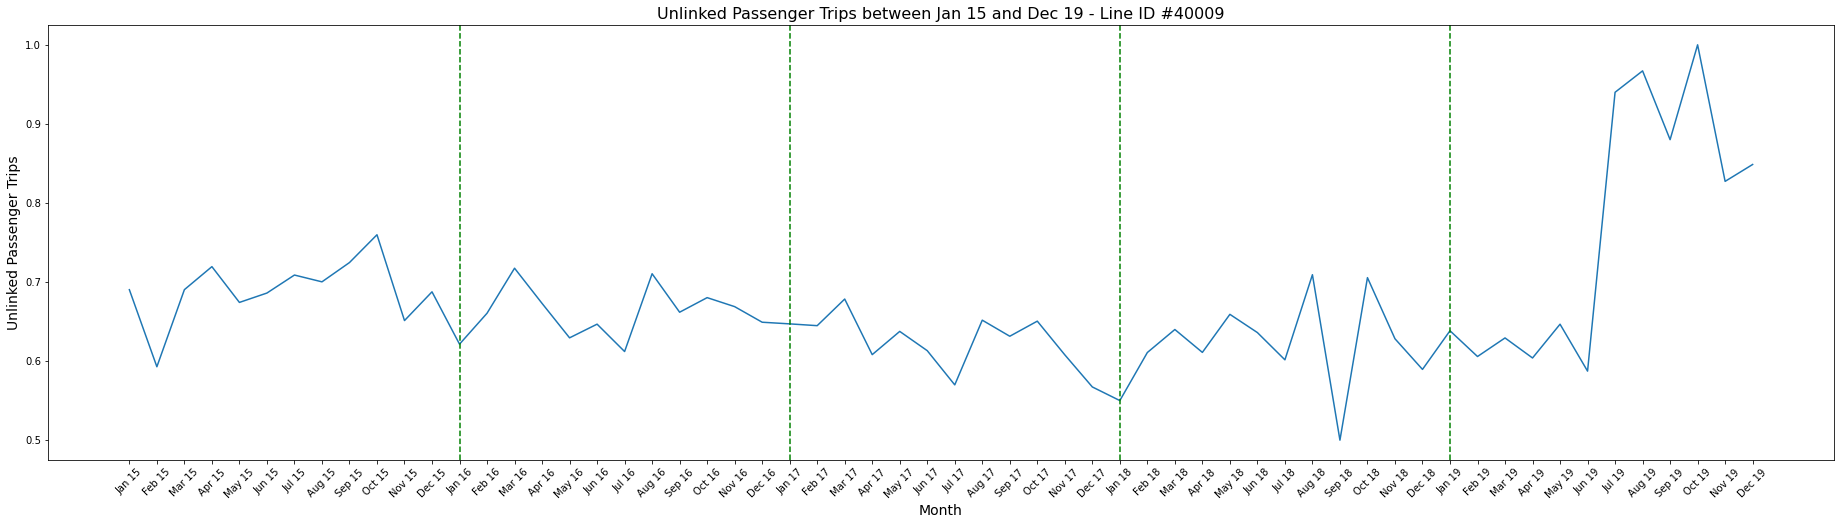

In [18]:
# For bullet #3 in the tables takeaway above: Graph line #40009 to investigate its UPT trend.

jan15_to_dec19_months = []

UPT_jan15_pos = transit_data_std.columns.get_loc('UPT_JAN15')
UPT_dec19_pos = transit_data_std.columns.get_loc('UPT_DEC19')

for month in transit_data_std.columns[UPT_jan15_pos : (UPT_dec19_pos + 1)]:
    month = month.replace('UPT_', '')
    month = month.replace('15', ' 15')
    month = month.replace('16', ' 16')
    month = month.replace('17', ' 17')
    month = month.replace('18', ' 18')
    month = month.replace('19', ' 19')
    month = month.capitalize()
    jan15_to_dec19_months.append(month)

# ------------------------------------

plt.figure(figsize = (32, 8))
plt.title('Unlinked Passenger Trips between Jan 15 and Dec 19 - Line ID #40009', fontsize = 16)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Unlinked Passenger Trips', fontsize = 14)
plt.xticks(rotation = 45)

plt.plot(jan15_to_dec19_months, transit_data_std.iloc[5, UPT_jan15_pos : (UPT_dec19_pos + 1)])

plt.axvline(x = 'Jan 16', color = 'green', ls = '--')
plt.axvline(x = 'Jan 17', color = 'green', ls = '--')
plt.axvline(x = 'Jan 18', color = 'green', ls = '--')
plt.axvline(x = 'Jan 19', color = 'green', ls = '--')

plt.show()

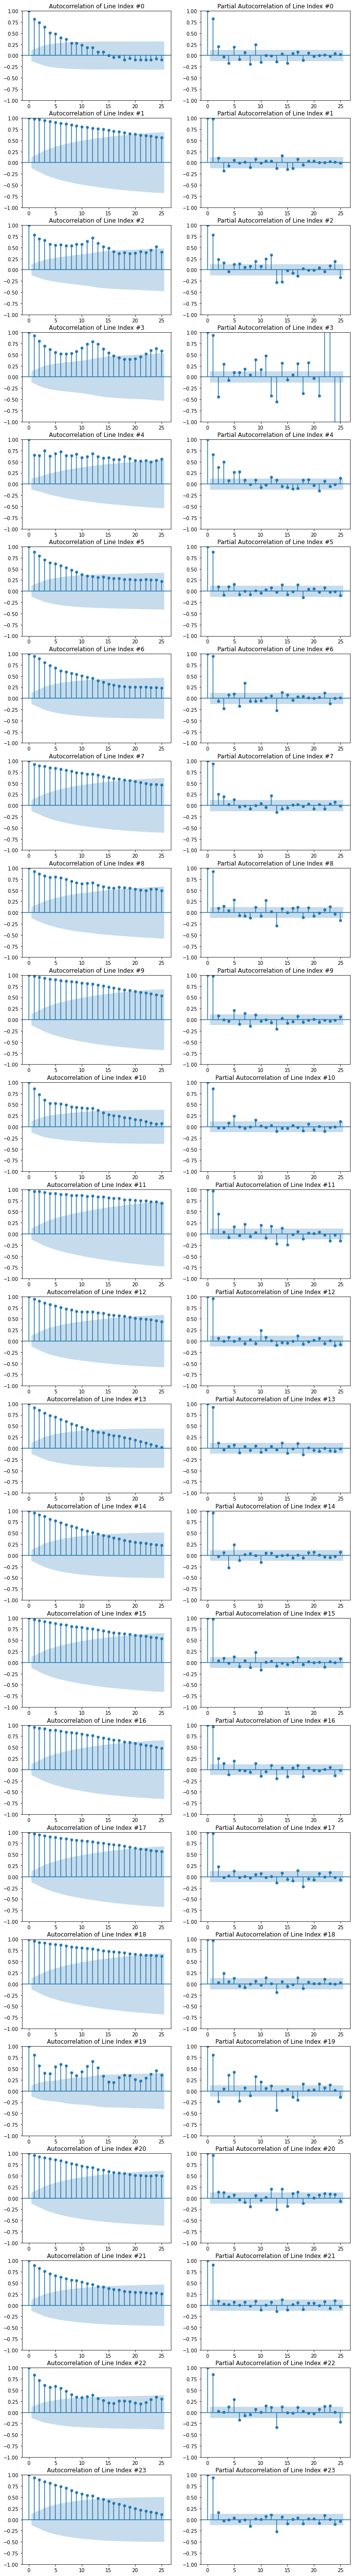

In [20]:
# Graph the autocorrelation and partial autocorrelation functions for each line.
# Knowing that these lines have most if not all of their most recent UPT history available, we graph the functions on their full history in order to capture a fuller picture of their ACFs/PACFs.

fig, axes = plt.subplots(24, 2, figsize = (12, 4 * len(TS_std_df_dict_nonulls)))

for df in range(len(TS_std_df_dict_nonulls)):
    warnings.simplefilter('ignore', FutureWarning)
    plot_acf(TS_std_df_dict_nonulls[df], lags = 25, zero = True, title = 'Autocorrelation of Line Index #' + str(df), ax = axes[df, 0])
    plot_pacf(TS_std_df_dict_nonulls[df], lags = 25, zero = True, title = 'Partial Autocorrelation of Line Index #' + str(df), ax = axes[df, 1])

plt.show()

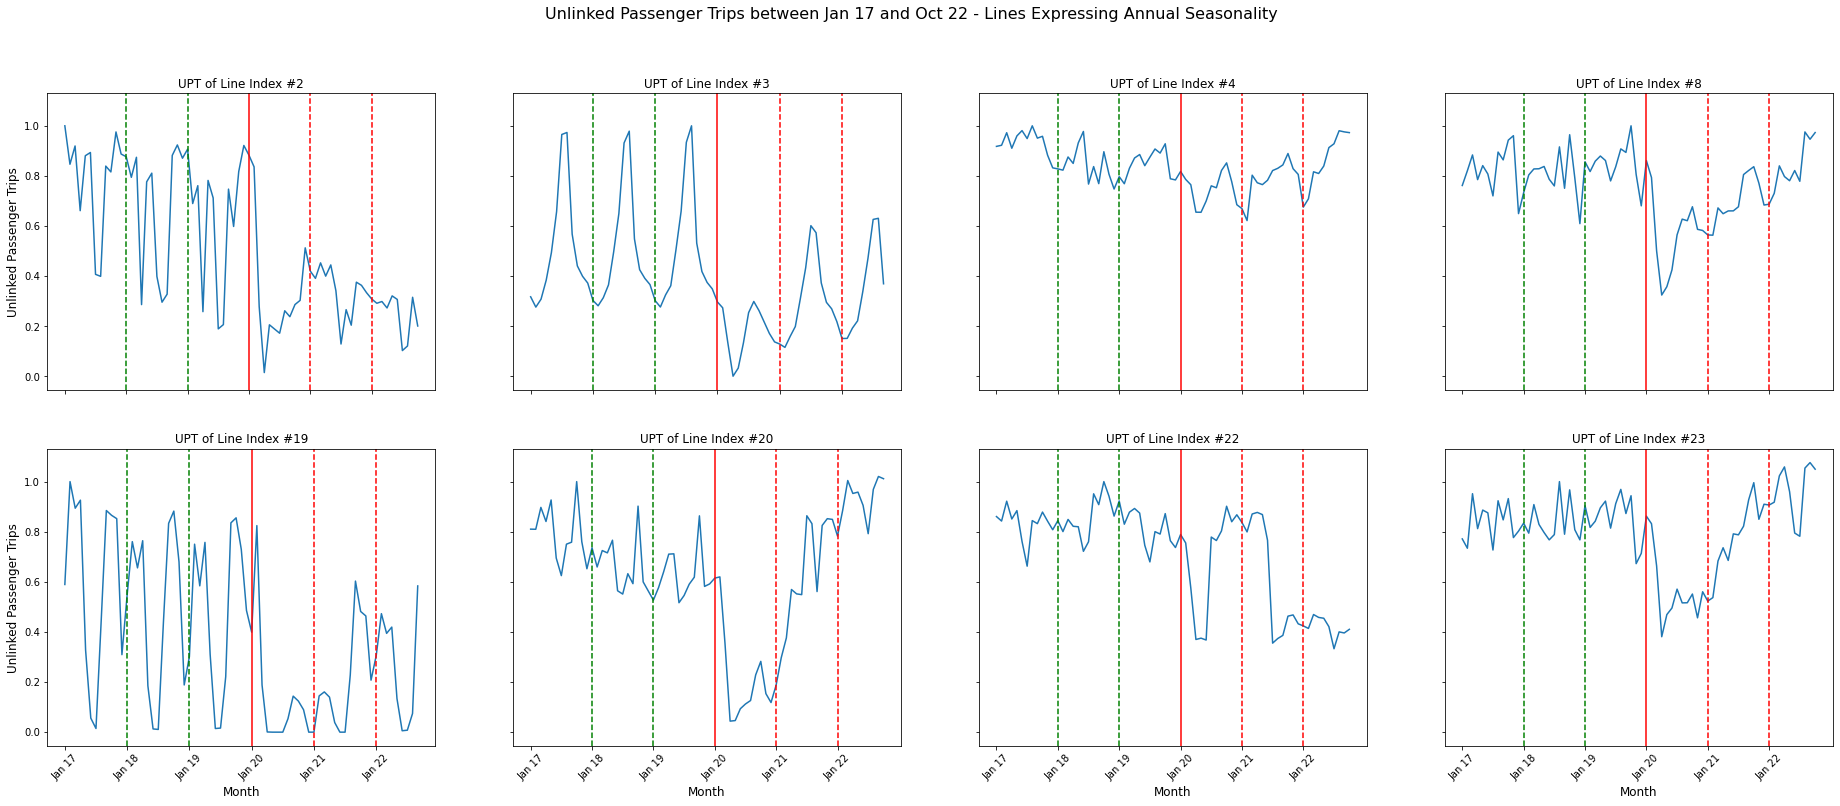

In [21]:
# The autocorrelation patterns of each line's UPT history all express some kind of trend or seasonality.
#  - Line indices expressing trend: all of them
#  - Line indices expressing annual seasonality: 2, 3, 4, 8, 19, 20, 22, 23
# Additionally, for all lines, the amplitude of the ACF gradually decreases, while the PACF largely cuts off after a certain lag, usually the first (although the 13th is often significant).
# These suggest that all lines are likely some AR(p) model, although p may be harder to discern for the lines whose PACFs have significant lags scattered beyond the first.

# Take a deeper look at the lines expressing annual seasonality.

transit_data_std_ann_seasonality_list = [2, 3, 4, 8, 19, 20, 22, 23]

jan17_to_oct22_months = []
UPT_jan17_pos = transit_data_std.columns.get_loc('UPT_JAN17')
UPT_oct22_pos = transit_data_std.columns.get_loc('UPT_OCT22')

for month in transit_data_std.columns[UPT_jan17_pos : (UPT_oct22_pos + 1)]:
    month = month.replace('UPT_', '')
    month = month.replace('17', ' 17')
    month = month.replace('18', ' 18')
    month = month.replace('19', ' 19')
    month = month.replace('20', ' 20')
    month = month.replace('21', ' 21')
    month = month.replace('22', ' 22')
    month = month.capitalize()
    jan17_to_oct22_months.append(month)

fig, axes = plt.subplots(2, 4, figsize = (32, 12), sharey = True)
plt.suptitle('Unlinked Passenger Trips between Jan 17 and Oct 22 - Lines Expressing Annual Seasonality', fontsize = 16)
ax_count_x = 0
ax_count_y = 0

for line in transit_data_std_ann_seasonality_list:
    axes[ax_count_x, ax_count_y].plot(jan17_to_oct22_months, transit_data_std.iloc[line, UPT_jan17_pos : (UPT_oct22_pos + 1)])

    axes[ax_count_x, ax_count_y].set_title('UPT of Line Index #' + str(line))
    axes[ax_count_x, ax_count_y].set_xlabel('Month', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_ylabel('Unlinked Passenger Trips', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_xticks([0, 12, 24, 36, 48, 60])
    axes[ax_count_x, ax_count_y].set_xticklabels(['Jan 17', 'Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22'], rotation = 45)
    axes[ax_count_x, ax_count_y].label_outer()

    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 18', color = 'green', ls = '--')
    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 19', color = 'green', ls = '--')
    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 20', color = 'red', ls = '-')
    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 21', color = 'red', ls = '--')
    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 22', color = 'red', ls = '--')

    ax_count_y += 1
    if ax_count_y == 4:
        ax_count_x +=1
        ax_count_y = 0

plt.show()

In [22]:
transit_data_std.iloc[transit_data_std_ann_seasonality_list, :]

5 digit NTD ID 4 digit NTD ID  \
2            20175           2175   
3            20217           2217   
4            30006           3006   
8            40108           4108   
19           70044            NaN   
20           70049         7049.0   
22           90032         9032.0   
23           90140         9140.0   

                                               Agency Modes TOS  Active  \
2                  Private Transportation Corporation    MB  PT  Active   
3                                Hampton Jitney, Inc.    CB  DO  Active   
4                    Greater Richmond Transit Company    MB  DO  Active   
8   Research Triangle Regional Public Transportati...    MB  DO  Active   
19                               University of Kansas    MB  PT  Active   
20                                 River Bend Transit    DR  DO  Active   
22         City of Phoenix Public Transit Department     MB  PT  Active   
23                                    City of Peoria     DR  DO  Active   

    Reporter Type                                 Organization Type   \
2   Full Reporter                     Private-For-Profit Corporation   
3   Full Reporter                     Private-For-Profit Corporation   
4   Full Reporter  Other Publicly-Owned or Privately Chartered Co...   
8   Full Reporter  Independent Public Agency or Authority of Tran...   
19  Full Reporter                                         University   
20  Full Reporter                     Private-Non-Profit Corporation   
22  Full Reporter  City, County or Local Government Unit or Depar...   
23  Full Reporter  City, County or Local Government Unit or Depar...   

      HQ City HQ State  UZA                   UZA Name  UZA Area SQ Miles  \
2    Brooklyn       NY    1  New York-Newark, NY-NJ-CT             3450.0   
3   CALVERTON       NY    1  New York-Newark, NY-NJ-CT             3450.0   
4    RICHMOND       VA   45               Richmond, VA              492.0   
8      DURHAM       NC  110                 Durham, NC              182.0   
19   LAWRENCE       KS  332               Lawrence, KS               30.0   
20  DAVENPORT       IA  134           Davenport, IA-IL              138.0   
22    PHOENIX       AZ   12           Phoenix-Mesa, AZ             1147.0   
23     PEORIA       AZ   12           Phoenix-Mesa, AZ             1147.0   

    UZA Population  Service Area SQ Miles  Service Area Population  \
2         18351295                   71.0                2465326.0   
3         18351295                 1215.0                9908805.0   
4           953556                  185.0                 492198.0   
8           347602                 1665.0                1924805.0   
19           88053                   15.0                  94934.0   
20          280051                 2791.0                 555862.0   
22         3629114                  520.0                2034618.0   
23         3629114                  179.0                 190985.0   

    Most Recent Report Year  FY End Month  FY End Year  Passenger Miles FY  \
2                    2021.0            12         2021           1851264.0   
3                    2021.0            12         2021          42639482.0   
4                    2021.0             6         2021          30464590.0   
8                    2021.0             6         2021          10010637.0   
19                   2021.0             6         2021            231781.0   
20                   2021.0             6         2021            429199.0   
22                   2021.0             6         2021         134736627.0   
23                   2021.0             6         2021             76153.0   

    Unlinked Passenger Trips FY  Unlinked Passenger Trips UZA Total  \
2                      353989.0                            353989.0   
3                      483740.0                            483740.0   
4                     6124472.0                           6241606.0   
8                     1118494.0  

__Objective__: Determine if each line is stationary, and make adjustments for stationarity as necessary.

In [23]:
# Run the Dickey-Fuller test on each line and print its p-value.
# The null hypothesis is that a unit root exists in the line's basic time series equation, and the line is therefore non-stationary,
# while the alternative hypothesis is that the unit root does not exist, and the line is therefore stationary.
# Run two versions of the test on each line: the first NOT also testing for trend stationarity, and the second also testing for trend stationarity.

# We see that nearly all of the lines fail to reject the null hypothesis that they are non-stationary.

ADF_all_pvals_wo_trend = {}
ADF_all_pvals_w_trend = {}

ADF_insig_results_wo_trend = []
ADF_sig_results_wo_trend = []
ADF_insig_results_w_trend = []
ADF_sig_results_w_trend = []

for df in range(len(TS_std_df_dict_nonulls)):
    ADF_results_wo_trend = adfuller(TS_std_df_dict_nonulls[df], regression = 'c', autolag = 'AIC')
    ADF_results_w_trend = adfuller(TS_std_df_dict_nonulls[df], regression = 'ct', autolag = 'AIC')
    p_val_wo_trend = ADF_results_wo_trend[1]
    p_val_w_trend = ADF_results_w_trend[1]

    ADF_all_pvals_wo_trend[df] = p_val_wo_trend
    ADF_all_pvals_w_trend[df] = p_val_w_trend

    if p_val_wo_trend >= .05:
        ADF_insig_results_wo_trend.append(df)
    else:
        ADF_sig_results_wo_trend.append(df)
    if p_val_w_trend >= .05:
        ADF_insig_results_w_trend.append(df)
    else:
        ADF_sig_results_w_trend.append(df)

    print('P-value of Dickey-Fuller test on line index #' + str(df) + ': ' + str(p_val_wo_trend) + ' (without trend); ' + str(p_val_w_trend) + ' (with trend)')

print('\nLine indices that are likely non-stationary while NOT accounting for trend: ' + str(ADF_insig_results_wo_trend))
print('Line indices that are likely stationary while NOT accounting for trend:     ' + str(ADF_sig_results_wo_trend))
print('Line indices that are likely non-stationary while accounting for trend:     ' + str(ADF_insig_results_w_trend))
print('Line indices that are likely stationary while accounting for trend:         ' + str(ADF_sig_results_w_trend))

P-value of Dickey-Fuller test on line index #0: 0.0620756015625658 (without trend); 0.22508505858543232 (with trend)
P-value of Dickey-Fuller test on line index #1: 0.4641733123595591 (without trend); 0.7702217719518543 (with trend)
P-value of Dickey-Fuller test on line index #2: 0.35740078076456705 (without trend); 0.9648900042572452 (with trend)
P-value of Dickey-Fuller test on line index #3: 0.6451570425757751 (without trend); 0.7556067274831891 (with trend)
P-value of Dickey-Fuller test on line index #4: 0.7773529725711057 (without trend); 0.26123746518202307 (with trend)
P-value of Dickey-Fuller test on line index #5: 0.24819036343267165 (without trend); 0.2885967431088639 (with trend)
P-value of Dickey-Fuller test on line index #6: 0.811033719669118 (without trend); 0.0974157831078889 (with trend)
P-value of Dickey-Fuller test on line index #7: 0.21629412755340405 (without trend); 0.740112096093447 (with trend)
P-value of Dickey-Fuller test on line index #8: 0.2071610623755321 (w

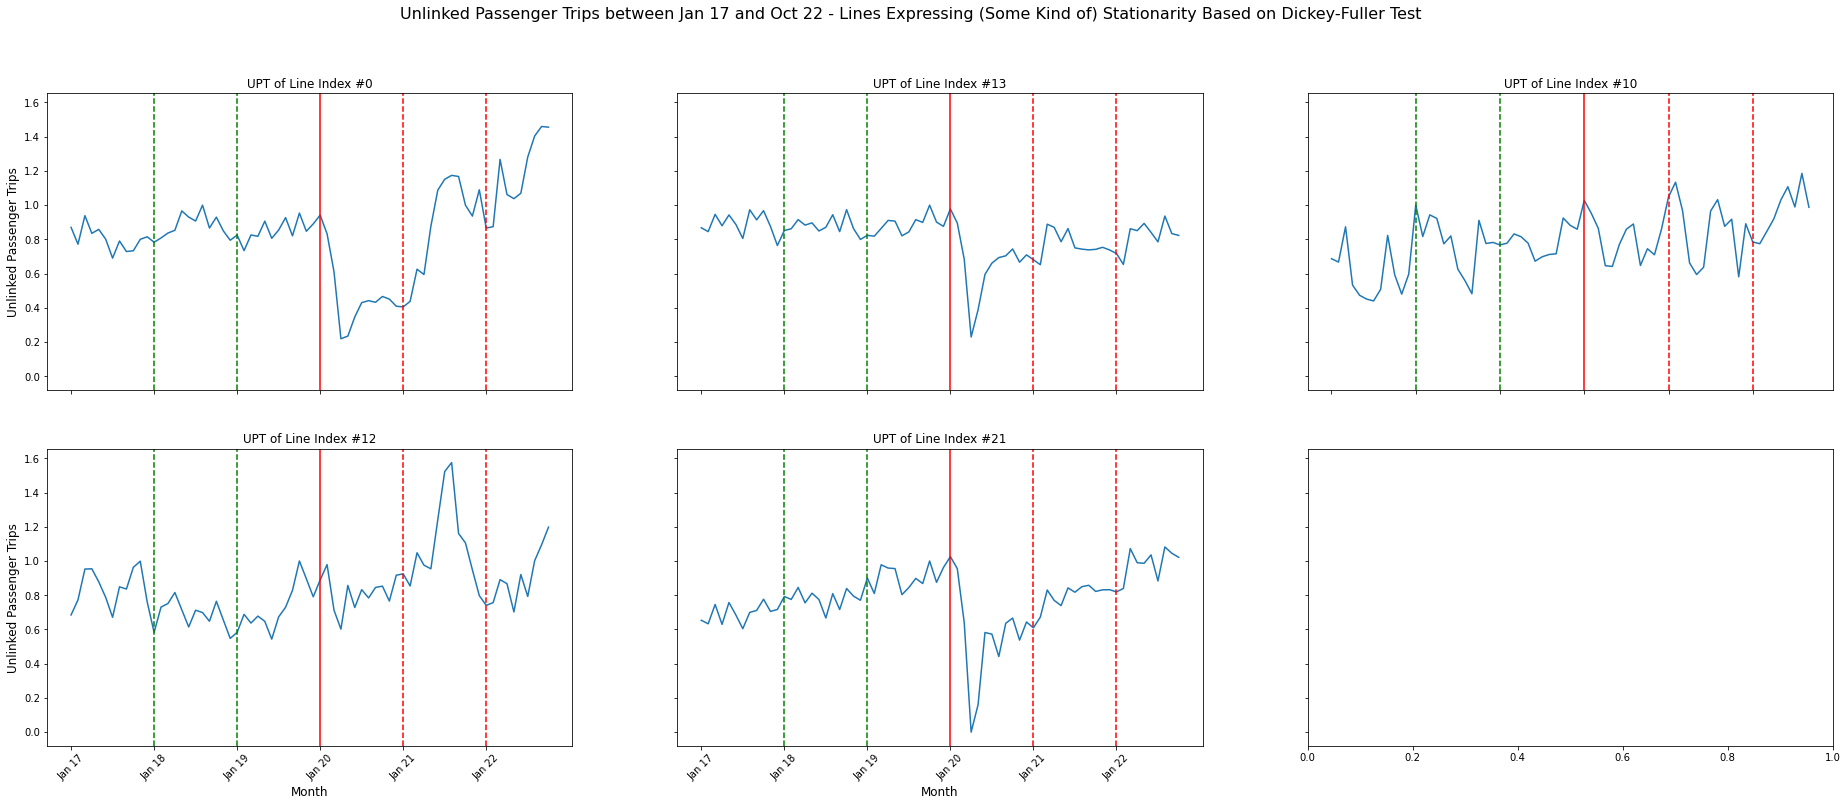

In [24]:
# Take a deeper look at the lines expressing some kind of stationarity based on the Dickey-Fuller test.

transit_data_std_ADF_stationarity_list = [0, 13, 10, 12, 21]

fig, axes = plt.subplots(2, 3, figsize = (32, 12), sharey = True)
plt.suptitle('Unlinked Passenger Trips between Jan 17 and Oct 22 - Lines Expressing (Some Kind of) Stationarity Based on Dickey-Fuller Test', fontsize = 16)
ax_count_x = 0
ax_count_y = 0

for line in transit_data_std_ADF_stationarity_list:
    axes[ax_count_x, ax_count_y].plot(jan17_to_oct22_months, transit_data_std.iloc[line, UPT_jan17_pos : (UPT_oct22_pos + 1)])

    axes[ax_count_x, ax_count_y].set_title('UPT of Line Index #' + str(line))
    axes[ax_count_x, ax_count_y].set_xlabel('Month', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_ylabel('Unlinked Passenger Trips', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_xticks([0, 12, 24, 36, 48, 60])
    axes[ax_count_x, ax_count_y].set_xticklabels(['Jan 17', 'Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22'], rotation = 45)
    axes[ax_count_x, ax_count_y].label_outer()

    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 18', color = 'green', ls = '--')
    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 19', color = 'green', ls = '--')
    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 20', color = 'red', ls = '-')
    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 21', color = 'red', ls = '--')
    axes[ax_count_x, ax_count_y].axvline(x = 'Jan 22', color = 'red', ls = '--')

    ax_count_y += 1
    if ax_count_y == 3:
        ax_count_x +=1
        ax_count_y = 0

plt.show()

In [25]:
transit_data_std.iloc[transit_data_std_ADF_stationarity_list, :]

5 digit NTD ID 4 digit NTD ID                                      Agency  \
0            10053           1053           Cape Ann Transportation Authority   
13           50169         5169.0                         Miami County, Ohio    
10           50039         5039.0  Saginaw Transit Authority Regional Service   
12           50157         5157.0    Butler County Regional Transit Authority   
21           80012         8012.0                Great Falls Transit District   

   Modes TOS  Active  Reporter Type  \
0     DR  PT  Active  Full Reporter   
13    DR  PT  Active  Full Reporter   
10    DR  DO  Active  Full Reporter   
12    DR  DO  Active  Full Reporter   
21    DR  DO  Active  Full Reporter   

                                   Organization Type       HQ City HQ State  \
0   Independent Public Agency or Authority of Tran...   GLOUCESTER       MA   
13  City, County or Local Government Unit or Depar...         TROY       OH   
10  Independent Public Agency or Authority of Tran...      Saginaw       MI   
12  Independent Public Agency or Authority of Tran...     HAMILTON       OH   
21  Independent Public Agency or Authority of Tran...  GREAT FALLS       MT   

    UZA              UZA Name  UZA Area SQ Miles  UZA Population  \
0    10      Boston, MA-NH-RI             1873.0         4181019   
13   59            Dayton, OH              351.0          724091   
10  253           Saginaw, MI               71.0          126265   
12   30  Cincinnati, OH-KY-IN              788.0         1624827   
21  422       Great Falls, MT               31.0           65207   

    Service Area SQ Miles  Service Area Population  Most Recent Report Year  \
0                    93.0                  60184.0                   2021.0   
13                  410.0                 106987.0                   2021.0   
10                   63.0                 200169.0                   2021.0   
12                  470.0                 390357.0                   2021.0   
21                   20.0                  64735.0                   2021.0   

    FY End Month  FY End Year  Passenger Miles FY  \
0              6         2021             87568.0   
13            12         2021            390342.0   
10             9         2021            189984.0   
12            12         2021            401110.0   
21             6         2021            108645.0   

    Unlinked Passenger Trips FY  Unlinked Passenger Trips UZA Total  \
0                       19062.0                            150290.0   
13                      38227.0                             38227.0   
10                      37911.0                            249818.0   
12                      46454.0                             46454.0   
21                      34557.0                            269882.0   

    Unlinked Passenger Trips UZA Perc  Average Trip Length FY  Fares FY  \
0                           12.683479                  4.5939   21373.0   
13                         100.000000                 10.2112  241915.0   
10                          15.175448                  5.0113  134234.0   
12                         100.000000                  8.6346  228170.0   
21                          12.804485                  3.1439   67526.0   

    Operating Expenses FY  Average Cost per Trip FY  \
0                830972.0                   43.5931   
13              1281589.0                   33.5258   
10              2742291.0                   72.3350   
12              2368007.0                   50.9753   
21               921153.0                   26.6560   

    Average Fares per Trip FY  UPT_JAN02  UPT_FEB02  UPT_MAR02  UPT_APR02  \
0                      1.1212   1.101363   0.975883   1.087033   1.131772   
13                     6.3284   0.000000   0.000000   0.000000   0.000000   
10                     3.5408   0.000000   0.000000   0.000000   0.000000   
12                     4.9117   1.241253   1.087754   1.324774   1.255361   
21        

In [26]:
# Run the same Dickey-Fuller test on all lines after taking the log of each value.

# Only 4 lines reject the null hypothesis that they are non-stationary after taking the log.
# However, 13 lines have lower p-values after taking the log.

ADF_all_pvals_log = {}

ADF_insig_results_log = []
ADF_sig_results_log = []

ADF_min_list_nolog = []
ADF_min_list_log = []

for df in range(len(TS_std_df_dict_nonulls)):
    warnings.simplefilter('ignore')
    
    ADF_results_log = adfuller(np.log(TS_std_df_dict_nonulls[df]).replace(-np.inf, np.nan).dropna(), regression = 'c', autolag = 'AIC')
    p_val_log = ADF_results_log[1]

    ADF_all_pvals_log[df] = p_val_log

    if p_val_log >= .05:
        ADF_insig_results_log.append(df)
    else:
        ADF_sig_results_log.append(df)
    
    if p_val_log >= ADF_all_pvals_w_trend[df]:
        ADF_min_list_nolog.append(df)
    else:
        ADF_min_list_log.append(df)

    #print('P-value of Dickey-Fuller test on line index #' + str(df) + ': ' + str(p_val_log))

print('\nLine indices that are likely non-stationary after taking the log: ' + str(ADF_insig_results_log))
print('Line indices that are likely stationary after taking the log:     ' + str(ADF_sig_results_log))

print('\nLine indices whose lowest p-values were from NOT taking the log: ' + str(ADF_min_list_nolog))
print('Line indices whose lowest p-values were from taking the log:     ' + str(ADF_min_list_log))


Line indices that are likely non-stationary after taking the log: [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23]
Line indices that are likely stationary after taking the log:     [3, 7, 13, 17]

Line indices whose lowest p-values were from NOT taking the log: [4, 5, 6, 10, 12, 16, 18, 19, 21, 22, 23]
Line indices whose lowest p-values were from taking the log:     [0, 1, 2, 3, 7, 8, 9, 11, 13, 14, 15, 17, 20]


In [27]:
# Create a version of the dataframe dictionary in which the appropriate lines are taken the log of, in accordance with the Dickey-Fuller tests.

TS_std_df_dict_log = TS_std_df_dict_nonulls.copy()

for line in ADF_min_list_log:
    warnings.simplefilter('ignore')
    TS_std_df_dict_log[line] = np.log(TS_std_df_dict_log[line]).replace(-np.inf, np.nan).dropna()

In [28]:
# Run the same Dickey-Fuller test on all lines after differencing by month, year, and both, after already considering taking the log.

# All lines reject the null hypothesis that they are non-stationary after differencing by month or by both month and year.
# All but 9 lines reject it after differencing by just year.
# 10 lines return the lowest p-values after differencing by just month, and the remaining 14 lines return the lowest p-values after differencing by both.

ADF_all_pvals_diff_mth = {}
ADF_all_pvals_diff_ann = {}
ADF_all_pvals_diff_bth = {}

ADF_insig_results_diff_mth = []
ADF_sig_results_diff_mth = []
ADF_insig_results_diff_ann = []
ADF_sig_results_diff_ann = []
ADF_insig_results_diff_bth = []
ADF_sig_results_diff_bth = []

ADF_min_list_nodiff = []
ADF_min_list_mth = []
ADF_min_list_ann = []
ADF_min_list_bth = []

for df in range(len(TS_std_df_dict_log)):
    ADF_results_diff_mth = adfuller(TS_std_df_dict_log[df].diff().dropna(), regression = 'c', autolag = 'AIC')
    ADF_results_diff_ann = adfuller(TS_std_df_dict_log[df].diff(12).dropna(), regression = 'c', autolag = 'AIC')
    ADF_results_diff_bth = adfuller(TS_std_df_dict_log[df].diff().diff(12).dropna(), regression = 'c', autolag = 'AIC')
    p_val_diff_mth = ADF_results_diff_mth[1]
    p_val_diff_ann = ADF_results_diff_ann[1]
    p_val_diff_bth = ADF_results_diff_bth[1]

    ADF_all_pvals_diff_mth[df] = p_val_diff_mth
    ADF_all_pvals_diff_ann[df] = p_val_diff_ann
    ADF_all_pvals_diff_bth[df] = p_val_diff_bth

    if p_val_diff_mth >= .05:
        ADF_insig_results_diff_mth.append(df)
    else:
        ADF_sig_results_diff_mth.append(df)
    if p_val_diff_ann >= .05:
        ADF_insig_results_diff_ann.append(df)
    else:
        ADF_sig_results_diff_ann.append(df)
    if p_val_diff_bth >= .05:
        ADF_insig_results_diff_bth.append(df)
    else:
        ADF_sig_results_diff_bth.append(df)
    
    if min(p_val_diff_mth, p_val_diff_ann, p_val_diff_bth) >= ADF_all_pvals_log[df]:
        ADF_min_list_nodiff.append(df)
    elif min(p_val_diff_mth, p_val_diff_ann, p_val_diff_bth) == p_val_diff_mth:
        ADF_min_list_mth.append(df)
    elif min(p_val_diff_mth, p_val_diff_ann, p_val_diff_bth) == p_val_diff_ann:
        ADF_min_list_ann.append(df)
    else:
        ADF_min_list_bth.append(df)

    #print('P-value of Dickey-Fuller test on line index #' + str(df) + ': ' + str(p_val_diff_mth) + ' (monthly diff); ' + str(p_val_diff_ann) + ' (annual diff); ' + str(p_val_diff_bth) + ' (both diffs)')

print('\nLine indices that are likely non-stationary after differencing by month: ' + str(ADF_insig_results_diff_mth))
print('Line indices that are likely stationary after differencing by month:     ' + str(ADF_sig_results_diff_mth))
print('Line indices that are likely non-stationary after differencing by year:  ' + str(ADF_insig_results_diff_ann))
print('Line indices that are likely stationary after differencing by year:      ' + str(ADF_sig_results_diff_ann))
print('Line indices that are likely non-stationary after differencing by both:  ' + str(ADF_insig_results_diff_bth))
print('Line indices that are likely stationary after differencing by both:      ' + str(ADF_sig_results_diff_bth))

print('\nLine indices whose lowest p-values were from NOT differencing:      ' + str(ADF_min_list_nodiff))
print('Line indices whose lowest p-values were from differencing by month: ' + str(ADF_min_list_mth))
print('Line indices whose lowest p-values were from differencing by year:  ' + str(ADF_min_list_ann))
print('Line indices whose lowest p-values were from differencing by both:  ' + str(ADF_min_list_bth))


Line indices that are likely non-stationary after differencing by month: []
Line indices that are likely stationary after differencing by month:     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Line indices that are likely non-stationary after differencing by year:  [0, 1, 9, 11, 14, 15, 16, 20, 22]
Line indices that are likely stationary after differencing by year:      [2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 17, 18, 19, 21, 23]
Line indices that are likely non-stationary after differencing by both:  []
Line indices that are likely stationary after differencing by both:      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

Line indices whose lowest p-values were from NOT differencing:      []
Line indices whose lowest p-values were from differencing by month: [1, 2, 3, 9, 10, 12, 14, 15, 17, 20]
Line indices whose lowest p-values were from differencing by year:  []
Line indices whose lowest p-values were from 

In [233]:
# Create a version of the dataframe dictionary in which each line is differenced in the way that makes it the most stationary, in accordance with the Dickey-Fuller tests.
# Also create a version in which each line is differenced by just month, regardless of the final method. This will help convert the transformed data back to its absolute values after the forecasting step.
# ***VERY IMPORTANT NOTE***: Originally this applied differencing based on which method resulted in the lowest p-value for the line. However, several lines whose lowest p-values were from differencing by month
#                            were still showing distinct seasonality. Since differencing by both month and year also results in stationarity for all lines, this method has been applied to them all instead.

TS_std_df_dict_diffs = TS_std_df_dict_log.copy()
TS_std_df_dict_diffs_mth = TS_std_df_dict_log.copy()

for line in ADF_min_list_mth:
    TS_std_df_dict_diffs[line] = TS_std_df_dict_diffs[line].diff().diff(12).dropna()
    TS_std_df_dict_diffs_mth[line] = TS_std_df_dict_diffs_mth[line].diff().dropna()
for line in ADF_min_list_ann:
    TS_std_df_dict_diffs[line] = TS_std_df_dict_diffs[line].diff().diff(12).dropna()
    TS_std_df_dict_diffs_mth[line] = TS_std_df_dict_diffs_mth[line].diff().dropna()
for line in ADF_min_list_bth:
    TS_std_df_dict_diffs[line] = TS_std_df_dict_diffs[line].diff().diff(12).dropna()
    TS_std_df_dict_diffs_mth[line] = TS_std_df_dict_diffs_mth[line].diff().dropna()

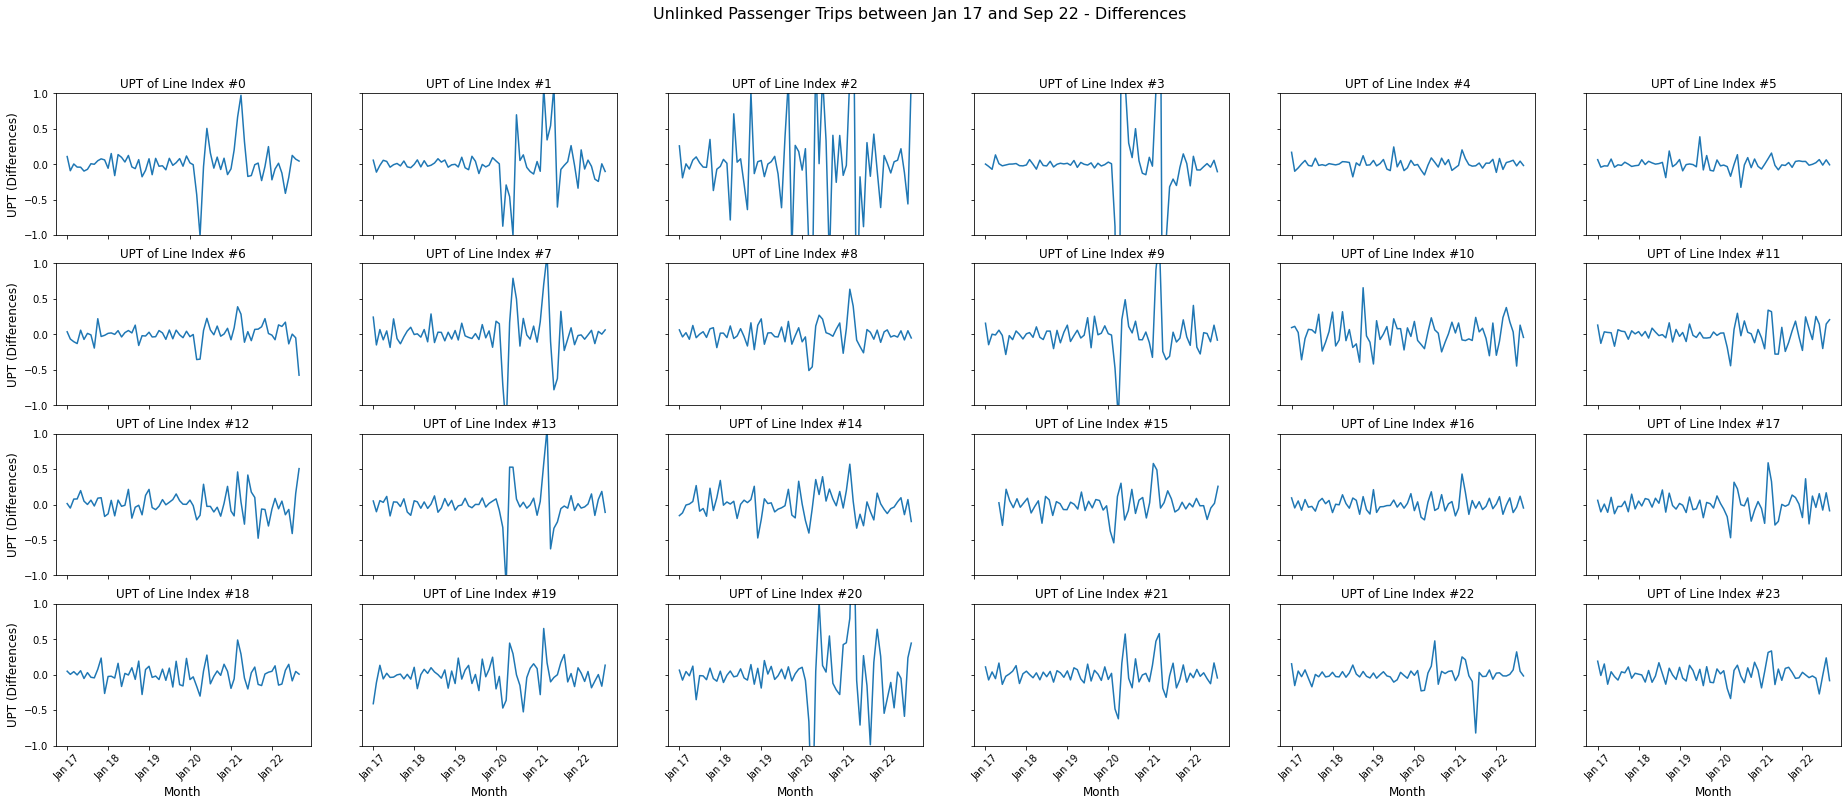

In [30]:
# Graph the transformed versions of the lines' UPT data.

# We can see that each lines' data is now generally centered around 0.
# Variance in each line does not exhibit any kind of pattern or trend, although it is more varied during post-COVID years, especially in 2020.

fig, axes = plt.subplots(4, 6, figsize = (32, 12), sharey = True)
plt.suptitle('Unlinked Passenger Trips between Jan 17 and Sep 22 - Differences', fontsize = 16)
ax_count_x = 0
ax_count_y = 0

for line in TS_std_df_dict_diffs:
    axes[ax_count_x, ax_count_y].plot(TS_std_df_dict_diffs[line].loc['2017-01-31':'2022-09-30', 'UPT'])

    axes[ax_count_x, ax_count_y].set_title('UPT of Line Index #' + str(line))
    axes[ax_count_x, ax_count_y].set_xlabel('Month', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_ylabel('UPT (Differences)', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_xticks(['2017-01-31', '2018-01-31', '2019-01-31', '2020-01-31', '2021-01-31', '2022-01-31'])
    axes[ax_count_x, ax_count_y].set_xticklabels(['Jan 17', 'Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22'], rotation = 45)
    axes[ax_count_x, ax_count_y].set_ylim([-1, 1])
    axes[ax_count_x, ax_count_y].label_outer()

    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 18', color = 'green', ls = '--')   # CONSIDER FIXING LATER: Plotting only y-values (instead of X vs. y) prevents this code from working properly.
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 19', color = 'green', ls = '--')   #                        However, not every date (X-value) has a matching data point (y-value), which is why the dates aren't being explicitly plotted.
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 20', color = 'red', ls = '-')
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 21', color = 'red', ls = '--')
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 22', color = 'red', ls = '--')

    ax_count_y += 1
    if ax_count_y == 6:
        ax_count_x +=1
        ax_count_y = 0

plt.show()

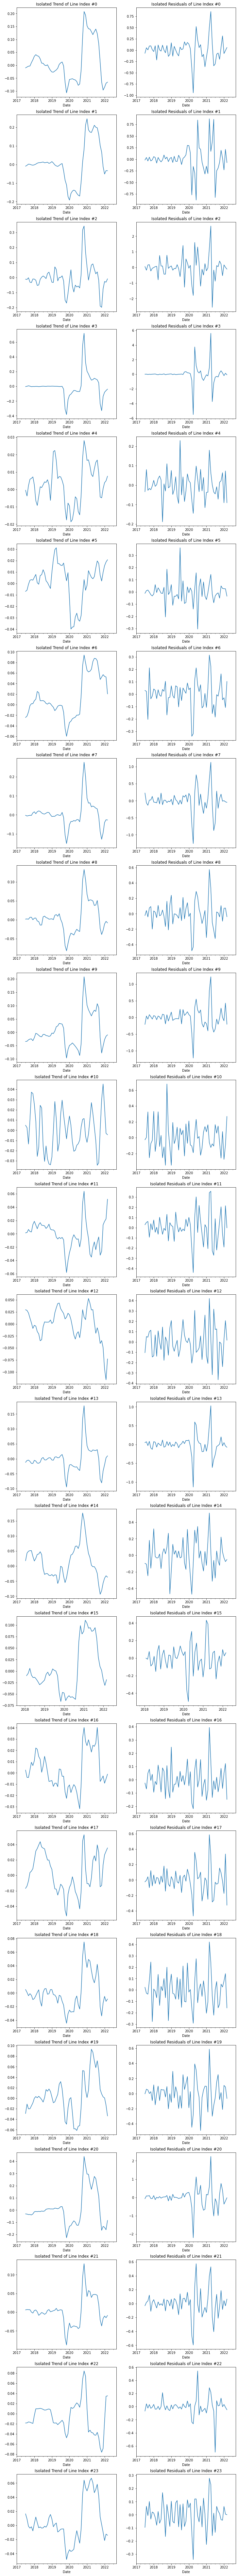

In [31]:
# Graph the isolated trend and residuals of the transformed versions, pulled via seasonal decomposition, to ensure there are no further patterns.

# Both trend and residuals are centered around zero for most lines.
# If anything, there is often a dip in both around 2020, when COVID first began and UPT tanked; as well as sharp increases immediately afterward, for when UPT initially picked back up, and at the beginning of 2021,
# when the pre-COVID ridership patterns resume to some extent.
# However, they revert back to around zero afterward.

fig, axes = plt.subplots(24, 2, figsize = (12, 6 * len(TS_std_df_dict_diffs)))

for df in range(len(TS_std_df_dict_diffs)):
    decomp_results = seasonal_decompose(TS_std_df_dict_diffs[df].loc['2017-01-31':'2022-09-30', 'UPT'], period = 12)
    decomp_results.trend.plot(title = 'Isolated Trend of Line Index #' + str(df), ax = axes[df, 0])
    decomp_results.resid.plot(title = 'Isolated Residuals of Line Index #' + str(df), ax = axes[df, 1])

plt.show()

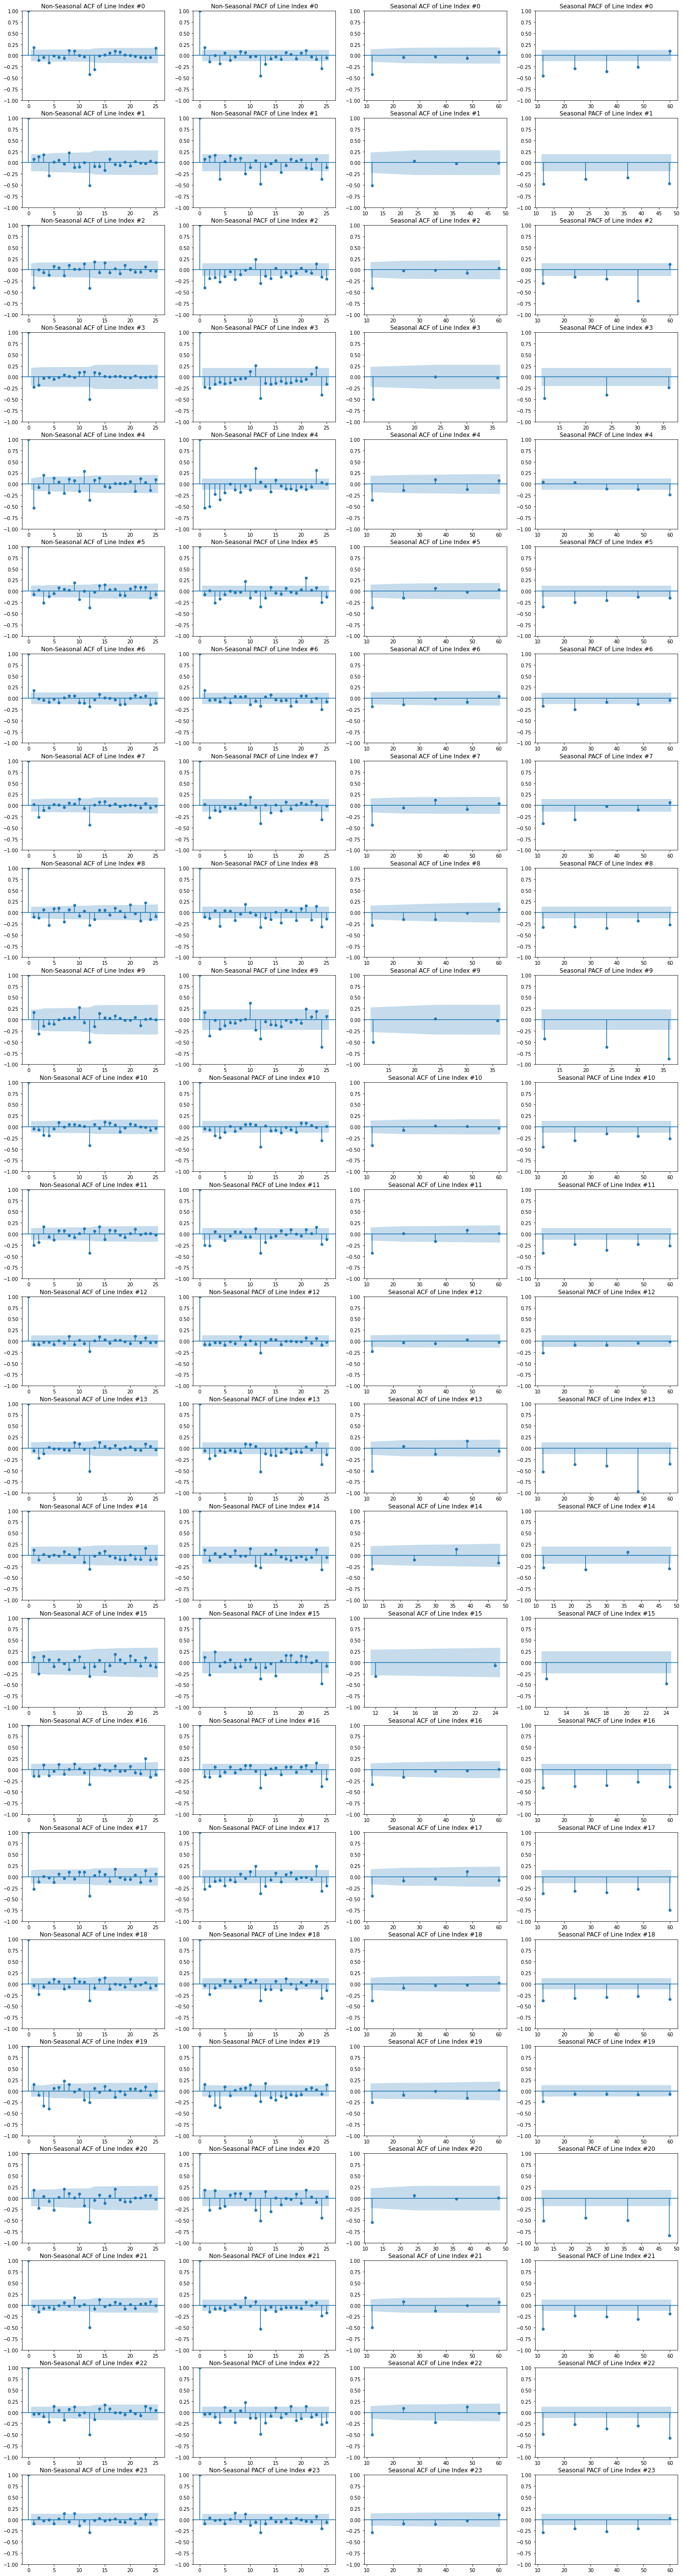

In [32]:
# Graph the autocorrelation and partial autocorrelation functions for each transformed line.
# Also graph the functions at multiple annual steps. 

# The non-seasonal ACFs of each line no longer indicate trend or seasonality, although many of them still indicate that the 1st and/or 12th lags are significant.
# However, there are many other significant lags scattered throughout both non-seasonal ACFs and PACFs for most lines.
# The transformed graphs and ADF tests suggest that all of these lines are now stationary, so these lags could simply be coincidental correlations without any causation, but we should still consider addressing them.
# Additionally, the seasonal ACFs and PACFs indicate that many of the lines are affected by multiple years of seasonality.

seasonal_lags = [12, 24, 36, 48, 60]

fig, axes = plt.subplots(24, 4, figsize = (24, 4 * len(TS_std_df_dict_diffs)))

for df in range(len(TS_std_df_dict_diffs)):
    warnings.simplefilter('ignore', FutureWarning)

    lag_number = min(math.floor(len(TS_std_df_dict_diffs[df]) / 12 / 2), 5)

    plot_acf(TS_std_df_dict_diffs[df], lags = 25, zero = True, title = 'Non-Seasonal ACF of Line Index #' + str(df), ax = axes[df, 0])
    plot_pacf(TS_std_df_dict_diffs[df], lags = 25, zero = True, title = 'Non-Seasonal PACF of Line Index #' + str(df), ax = axes[df, 1])
    plot_acf(TS_std_df_dict_diffs[df], lags = seasonal_lags[:lag_number], zero = True, title = 'Seasonal ACF of Line Index #' + str(df), ax = axes[df, 2])
    plot_pacf(TS_std_df_dict_diffs[df], lags = seasonal_lags[:lag_number], zero = True, title = 'Seasonal PACF of Line Index #' + str(df), ax = axes[df, 3])    

plt.show()

__Objective__: Determine the model orders for each line.

In [33]:
# Split each line's data into training and test sets.
# Because the test set must consist of some portion of the post-COVID data, of which there is less than three years' worth, it will be limited to the data from January 2022 to October 2022 (10 months).

TS_std_df_dict_diffs_train = {}
TS_std_df_dict_diffs_test = {}

for df in TS_std_df_dict_diffs:
    TS_std_df_dict_diffs_train[df] = TS_std_df_dict_diffs[df].loc[:'2021-12-31']
    TS_std_df_dict_diffs_test[df] = TS_std_df_dict_diffs[df].loc['2022-01-31':]

In [34]:
# This code originally ran all iterations of ARMA models based on provided AR and MA order parameters.
# However, it did not account for the seasonality aspect, which SARIMA will do.
# This code is therefore here for reference only.

'''
# For each line, run a variety of AR(p), MA(q), and ARMA(p, q) models.
# As mentioned earlier, the initial ACF and PACF of each line suggested that they were likely some sort of AR(p) model, but we should try at least one MA(q) model to confirm it's truly not the best fit.
# Then compile the models' AICs into a table for comparison. (We refer to AIC instead of BIC for model accuracy in this case because we want the best predictive model rather than explanatory model.)

max_order_AR = 12
max_order_MA = 16
max_order_AR_for_ARMA = 6   # This *and* max_order_MA_for_ARMA must be greater than 0 to produce any ARMA results.
max_order_MA_for_ARMA = 6   # This *and* max_order_AR_for_ARMA must be greater than 0 to produce any ARMA results.

models_list = []

for order_AR in range(1, max_order_AR + 1):
    models_list.append('AR(' + str(order_AR) + ')')
for order_MA in range(1, max_order_MA + 1):
    models_list.append('MA(' + str(order_MA) + ')')
for order_AR in range(1, max_order_AR_for_ARMA + 1):
    for order_MA in range(1, max_order_MA_for_ARMA + 1):
        models_list.append('ARMA(' + str(order_AR) + ', ' + str(order_MA) + ')')
model_results_table = pd.DataFrame(columns = models_list)

for df in range(len(TS_std_df_dict_diffs)):
    #warnings.simplefilter('ignore')
    model_results_list = []
    
    if max_order_AR > 0:
        for order_AR in range(1, max_order_AR + 1):
            model = ARIMA(TS_std_df_dict_diffs[df], order = (order_AR, 0, 0))
            results = model.fit()
            model_results_list.append(results.aic)

    if max_order_MA > 0:
        for order_MA in range(1, max_order_MA + 1):
            model = ARIMA(TS_std_df_dict_diffs[df], order = (0, 0, order_MA))
            results = model.fit()
            model_results_list.append(results.aic)

    if max_order_AR_for_ARMA > 0 and max_order_MA_for_ARMA > 0:
        for order_AR in range(1, max_order_AR_for_ARMA + 1):
            for order_MA in range(1, max_order_MA_for_ARMA + 1):
                model = ARIMA(TS_std_df_dict_diffs[df], order = (order_AR, 0, order_MA))
                results = model.fit()
                model_results_list.append(results.aic)
    
    model_results_table.loc[len(model_results_table.index)] = model_results_list

model_results_table['Model with Least AIC'] = ''
for df in range(len(model_results_table)):
    model_results_list_min = min(model_results_table.iloc[df, :-1])
    model_results_table.loc[df, 'Model with Least AIC'] = model_results_table.iloc[df, :][model_results_table.iloc[df, :] == model_results_list_min].index

model_results_table
'''

"\n# For each line, run a variety of AR(p), MA(q), and ARMA(p, q) models.\n# As mentioned earlier, the initial ACF and PACF of each line suggested that they were likely some sort of AR(p) model, but we should try at least one MA(q) model to confirm it's truly not the best fit.\n# Then compile the models' AICs into a table for comparison. (We refer to AIC instead of BIC for model accuracy in this case because we want the best predictive model rather than explanatory model.)\n\nmax_order_AR = 12\nmax_order_MA = 16\nmax_order_AR_for_ARMA = 6   # This *and* max_order_MA_for_ARMA must be greater than 0 to produce any ARMA results.\nmax_order_MA_for_ARMA = 6   # This *and* max_order_AR_for_ARMA must be greater than 0 to produce any ARMA results.\n\nmodels_list = []\n\nfor order_AR in range(1, max_order_AR + 1):\n    models_list.append('AR(' + str(order_AR) + ')')\nfor order_MA in range(1, max_order_MA + 1):\n    models_list.append('MA(' + str(order_MA) + ')')\nfor order_AR in range(1, max_or

In [35]:
# For each line, run a variety of SARIMA(p, 0, q)(P, 0, Q, 12) models. d = 0 and D = 0 for all models because differencing has already been accounted for.
# Save the models in a dictionary.

models_dict = {}

for df in range(len(TS_std_df_dict_diffs_train)):
    model = pm.auto_arima(TS_std_df_dict_diffs_train[df], max_p = 6, d = 0, max_q = 6, seasonal = True, max_P = 5, D = 0, max_Q = 5, m = 12, information_criterion = 'aic', trace = False, error_action = 'warn', stepwise = True)
    print('Best model orders for Line Index #' + str(df) + ': ' + str(model.order) + ' (non-seasonal); ' + str(model.seasonal_order) + ' (seasonal)')
    models_dict[df] = model

Best model orders for Line Index #0: (1, 0, 2) (non-seasonal); (5, 0, 0, 12) (seasonal)
Best model orders for Line Index #1: (0, 0, 4) (non-seasonal); (1, 0, 1, 12) (seasonal)
Best model orders for Line Index #2: (1, 0, 1) (non-seasonal); (0, 0, 1, 12) (seasonal)
Best model orders for Line Index #3: (1, 0, 1) (non-seasonal); (1, 0, 1, 12) (seasonal)
Best model orders for Line Index #4: (4, 0, 1) (non-seasonal); (0, 0, 1, 12) (seasonal)
Best model orders for Line Index #5: (0, 0, 4) (non-seasonal); (2, 0, 1, 12) (seasonal)
Best model orders for Line Index #6: (0, 0, 0) (non-seasonal); (1, 0, 1, 12) (seasonal)
Best model orders for Line Index #7: (1, 0, 2) (non-seasonal); (0, 0, 1, 12) (seasonal)
Best model orders for Line Index #8: (0, 0, 0) (non-seasonal); (4, 0, 1, 12) (seasonal)
Best model orders for Line Index #9: (0, 0, 0) (non-seasonal); (4, 0, 0, 12) (seasonal)
Best model orders for Line Index #10: (2, 0, 2) (non-seasonal); (1, 0, 1, 12) (seasonal)
Best model orders for Line Inde

Plot diagnostics for Line Index #0:


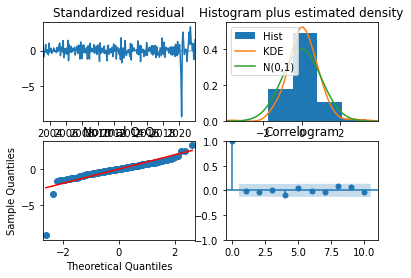

Plot diagnostics for Line Index #1:


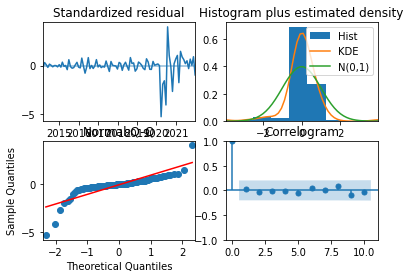

Plot diagnostics for Line Index #2:


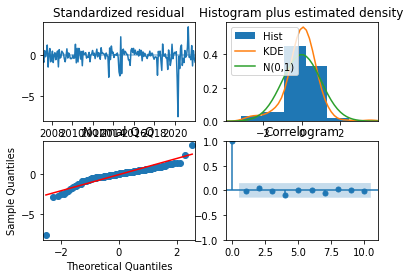

Plot diagnostics for Line Index #3:


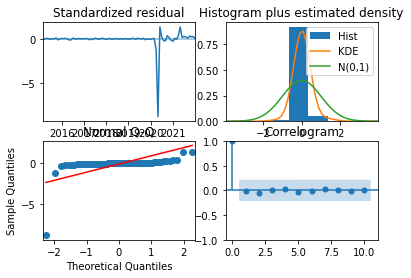

Plot diagnostics for Line Index #4:


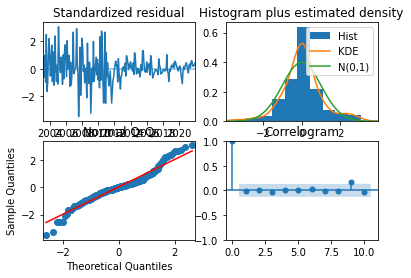

Plot diagnostics for Line Index #5:


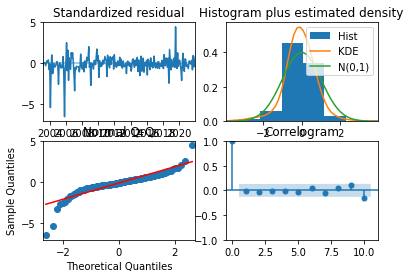

Plot diagnostics for Line Index #6:


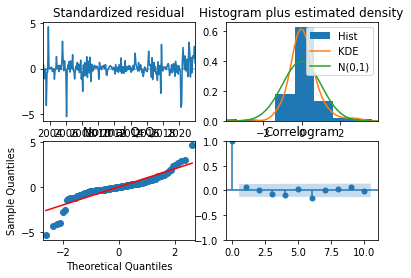

Plot diagnostics for Line Index #7:


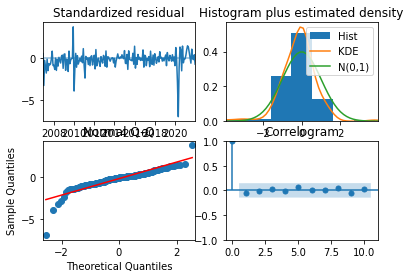

Plot diagnostics for Line Index #8:


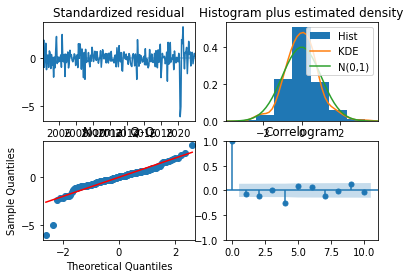

Plot diagnostics for Line Index #9:


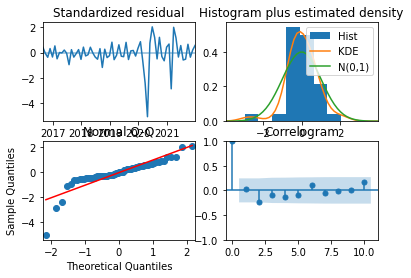

Plot diagnostics for Line Index #10:


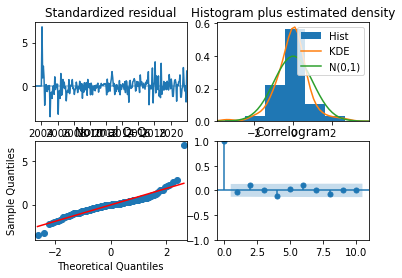

Plot diagnostics for Line Index #11:


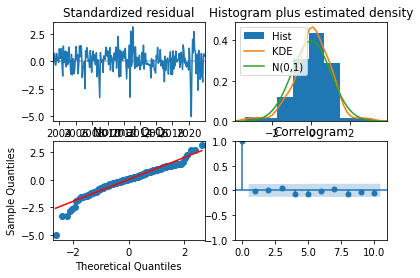

Plot diagnostics for Line Index #12:


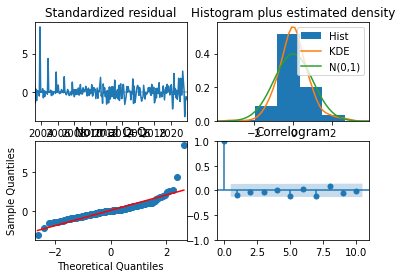

Plot diagnostics for Line Index #13:


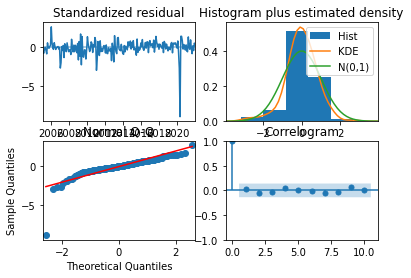

Plot diagnostics for Line Index #14:


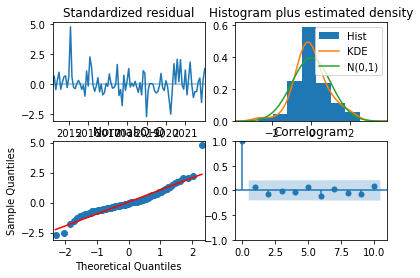

Plot diagnostics for Line Index #15:


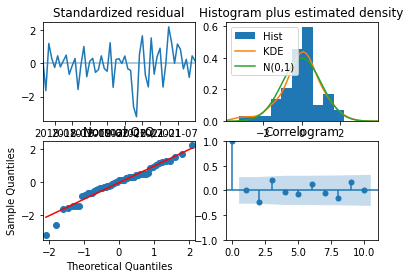

Plot diagnostics for Line Index #16:


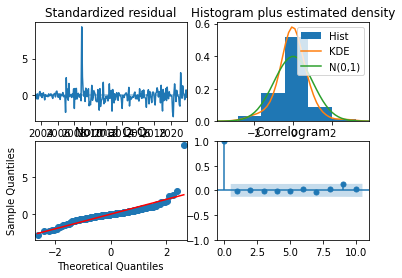

Plot diagnostics for Line Index #17:


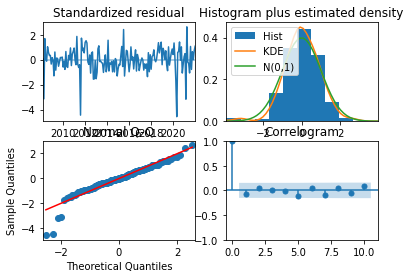

Plot diagnostics for Line Index #18:


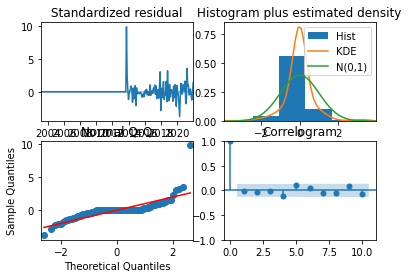

Plot diagnostics for Line Index #19:


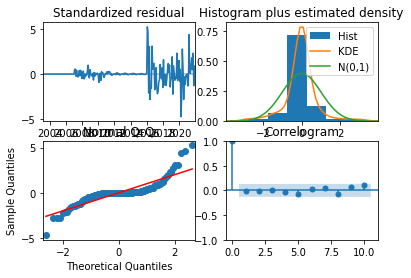

Plot diagnostics for Line Index #20:


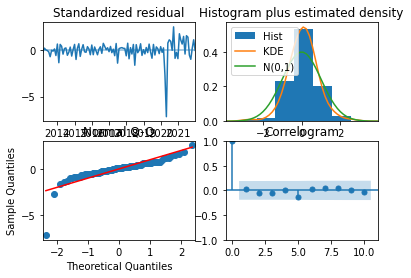

Plot diagnostics for Line Index #21:


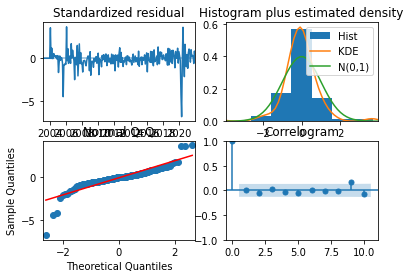

Plot diagnostics for Line Index #22:


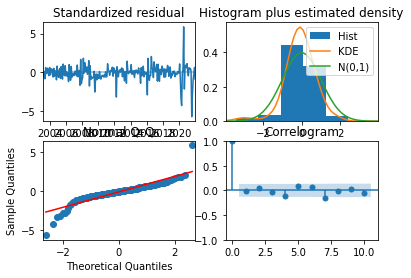

Plot diagnostics for Line Index #23:


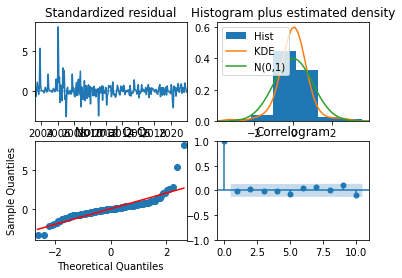

In [36]:
# Show the plot diagnostics of each model.

# - The standardized residual plots show that the residuals are generally centered around zero for the line's entire UPT history. There are occasionally longer streaks of zeroes for when a line is out of service
#   and therefore has zero UPT.
# - The histograms are generally bell-curved and centered around zero. However, they are also very heavily distributed around zero, much more so than in a Gaussian normal distribution.
# - The normal Q-Q plots further support the histogram data. For some plots the points lie in a straight line, but for others they curve first upward and then downward around zero,
#   indicating that more residuals are closer to zero than they should be.
# - ***VERY IMPORTANT NOTE***: Multiple combinations of transformations were applied and tested to the lines' data before arriving at this point. Each combination here expressed stationarity both visually and by ADF test,
#                              and in some cases was the only one that could do so. All others resulted in weird ACFs/PACFs or did not result in stationarity or normalized residuals. The transformations being used now
#                              are therefore the ones that lead to the most normalized residuals while still resulting in stationarity and sensible ACFs/PACFs. It is unknown what further transformations can be applied
#                              to these models that will result in both stationarity and normalized residuals for them. It could be possible that there are none, perhaps due to the many zero UPT values occasionally present
#                              which can't be imputed or otherwise adjusted, or due to COVID having a massive one-time effect on the data.
#                              In the interest of time, these iterations of models and data will be used, but consider revisiting them in the future after gaining more experience.
# - The correlograms show either no significant lags or trends in significant lags, indicating that there is no significant trend or seasonal data being left out of the models.

for model in range(len(models_dict)):
    print('Plot diagnostics for Line Index #' + str(model) + ':')
    models_dict[model].plot_diagnostics()
    plt.show()

In [37]:
# Print the model summaries.

# The p-values for the Ljung-Box tests are all greater than 0.05, suggesting that the residuals within each model are not correlated with each other.
# The p-values for the Jarque-Bera tests are all approximately zero, suggesting in tandem with the diagnostics plots that the residuals within each model do not quite follow a normal distribution.

for model in range(len(models_dict)):
    print('Model summary for Line Index #' + str(model) + ':')
    print(models_dict[model].summary())
    print('\n')

Model summary for Line Index #0:
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  227
Model:             SARIMAX(1, 0, 2)x(5, 0, [], 12)   Log Likelihood                 180.289
Date:                             Tue, 14 Mar 2023   AIC                           -342.577
Time:                                     19:28:03   BIC                           -311.753
Sample:                                 02-28-2003   HQIC                          -330.139
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8436      0.113      7.451      0.000       0.622       

In [38]:
# Print the MAE of the residuals of the models on the training sets.
# These are largely meaningless right now and are difficult even to compare to each other, since, compared to the original data, all are differenced and some are taken the log of.

for model in range(len(models_dict)):
    print('MAE of residuals for Line Index #' + str(model) + ': ' + str(np.mean(np.abs(models_dict[model].resid()))))

MAE of residuals for Line Index #0: 0.06755094012407567
MAE of residuals for Line Index #1: 0.08467728065734621
MAE of residuals for Line Index #2: 0.24613092203387657
MAE of residuals for Line Index #3: 0.15818802786392244
MAE of residuals for Line Index #4: 0.16452939695423696
MAE of residuals for Line Index #5: 0.05134932861048738
MAE of residuals for Line Index #6: 0.05152720912188106
MAE of residuals for Line Index #7: 0.12744663917579083
MAE of residuals for Line Index #8: 0.06781533927973782
MAE of residuals for Line Index #9: 0.13435131677859494
MAE of residuals for Line Index #10: 0.08260101934860105
MAE of residuals for Line Index #11: 0.0589502349306834
MAE of residuals for Line Index #12: 0.08943973185528456
MAE of residuals for Line Index #13: 0.08314804253680122
MAE of residuals for Line Index #14: 0.11620522762260324
MAE of residuals for Line Index #15: 0.11768535845751842
MAE of residuals for Line Index #16: 0.048734802328314564
MAE of residuals for Line Index #17: 0.07

__Objective__: Forecast the transformed UPT for each line.

In [39]:
# Test each line's model by forecasting its UPT from Jan 2022 to Oct 2022, and save the forecasts in a dictionary.

test_forecasts_dict = {}

for model in range(len(models_dict)):
    forecast = models_dict[model].predict(n_periods = len(TS_std_df_dict_diffs_test[model]))
    forecast_df = pd.DataFrame(forecast, columns = ['UPT (Predicted)'])
    test_forecasts_dict[model] = forecast_df

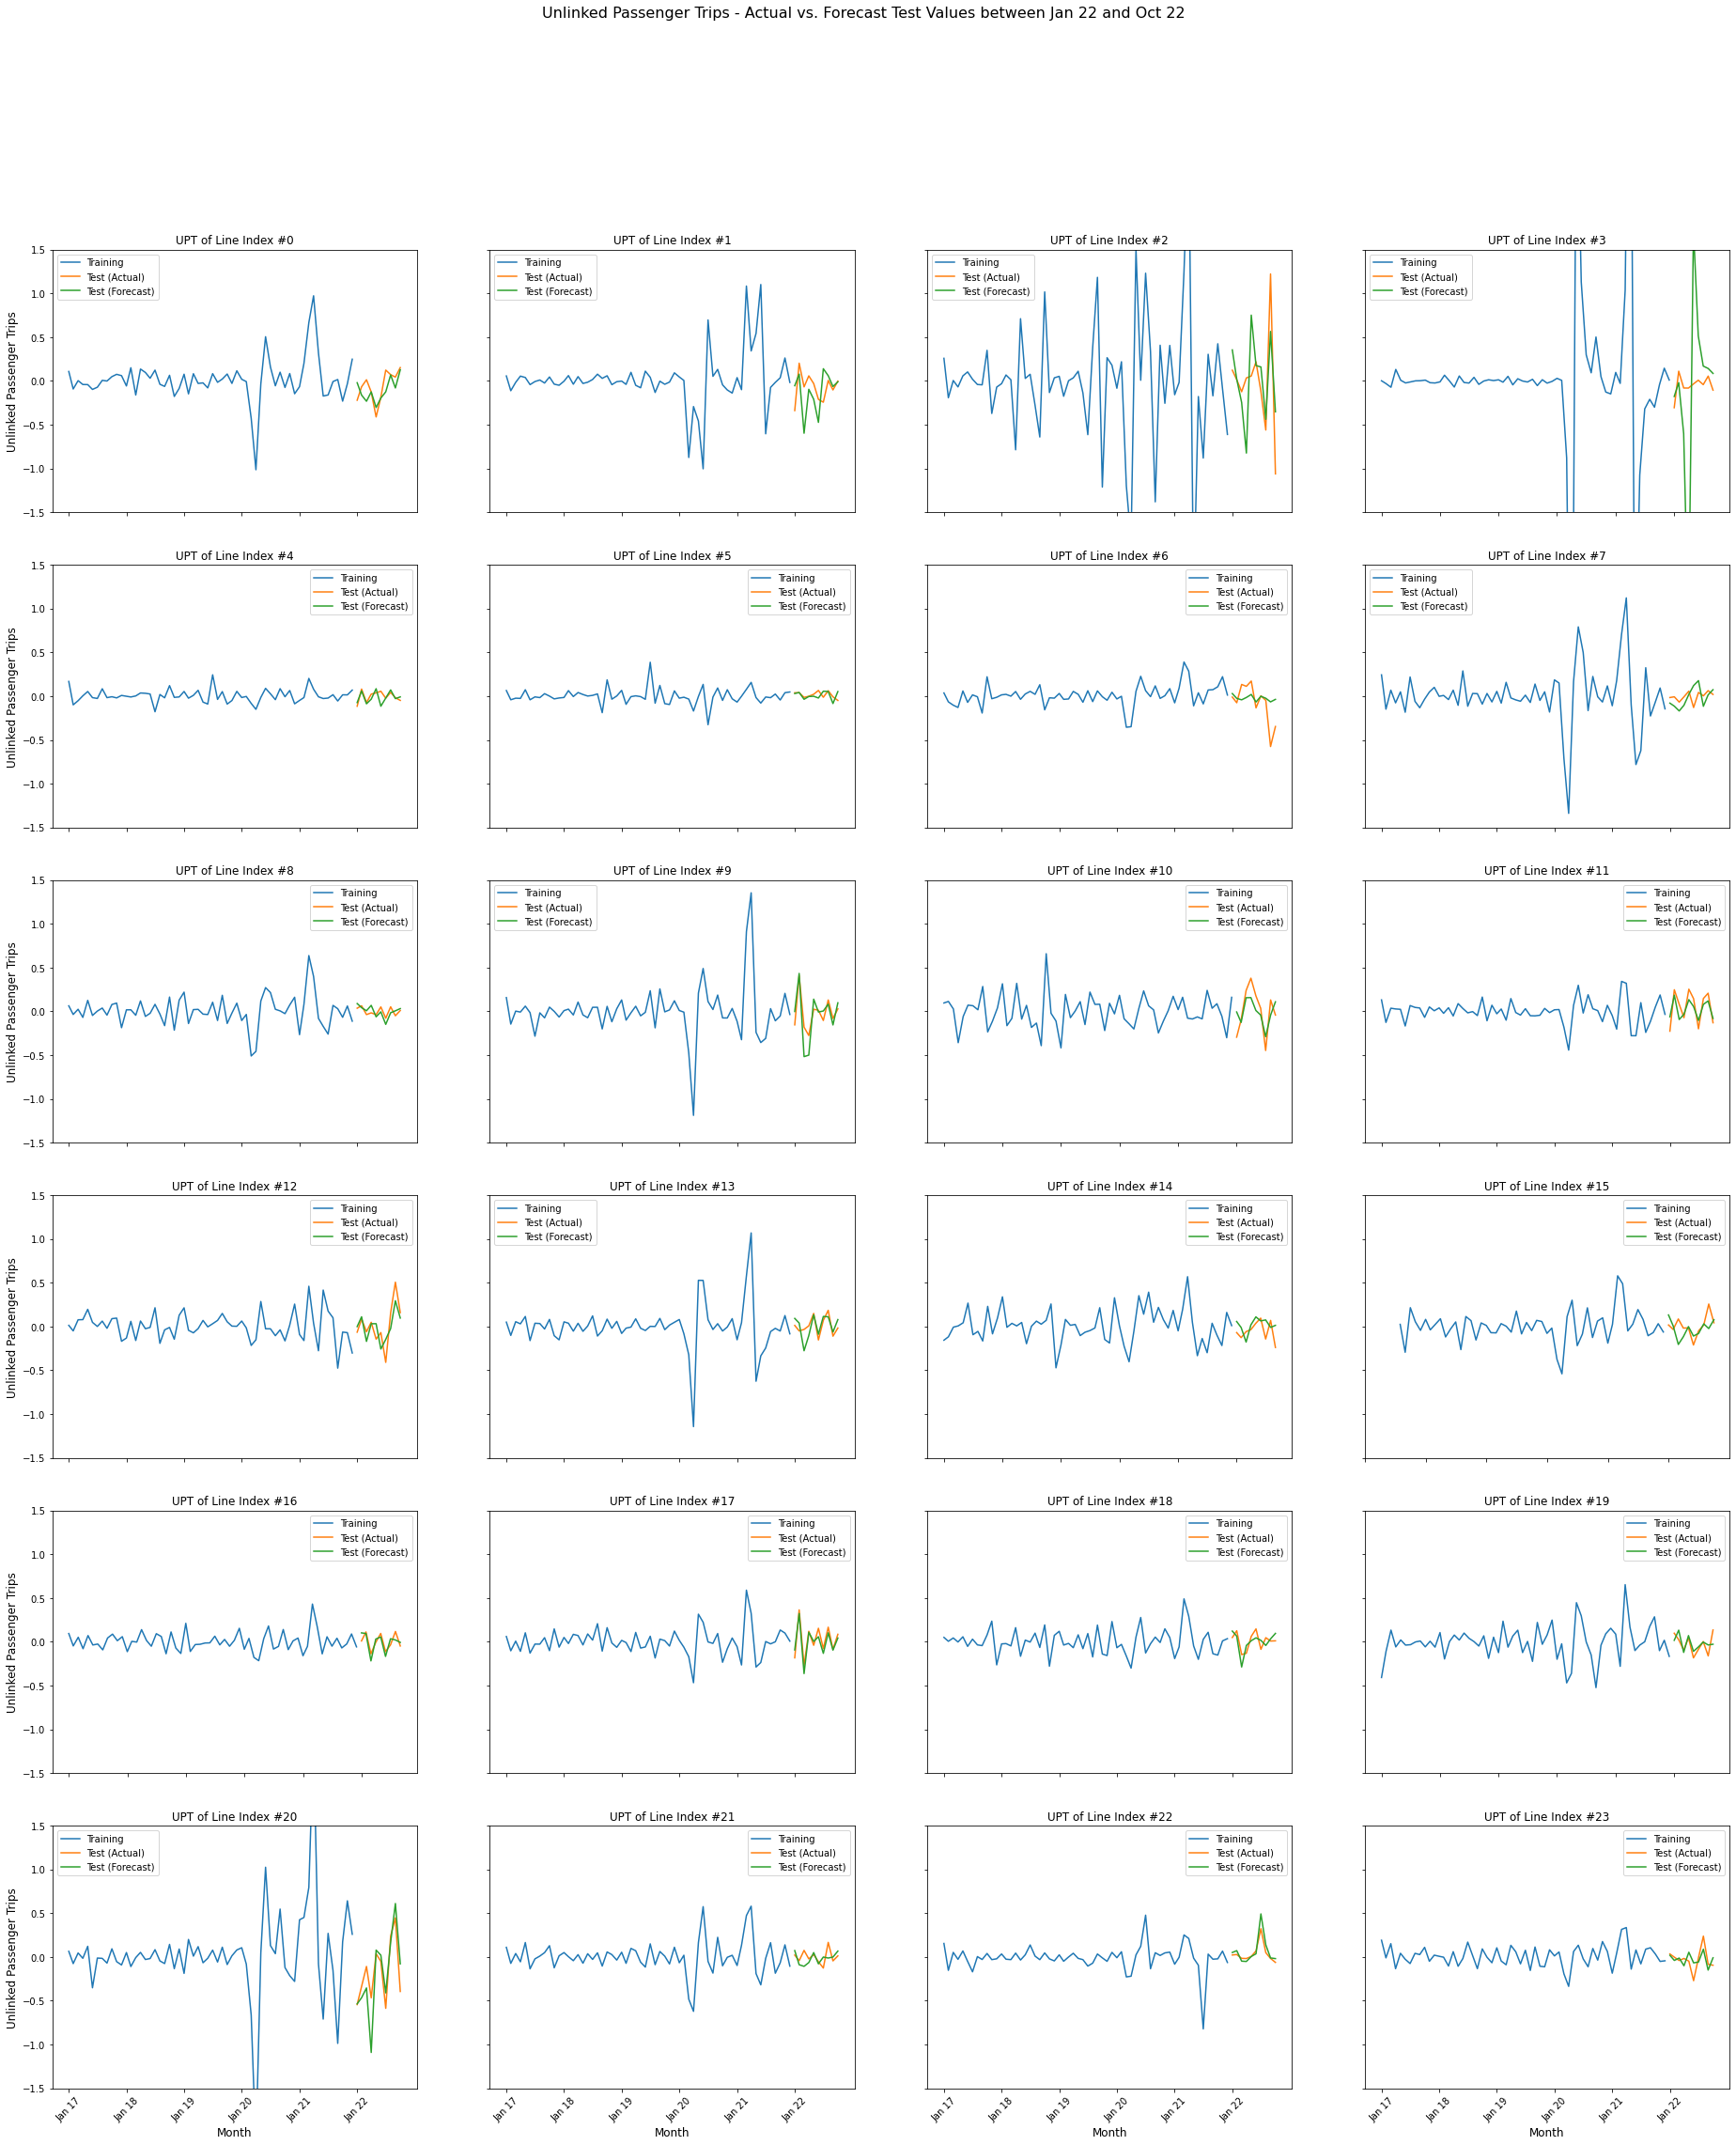

In [424]:
# Graph the test forecasts to compare against the actual values in the test sets.

# Visually, the forecasts provide mixed results. Some are quite similar to the actual values in the test sets, while some are wildly different.
# Additionally, how much similarity a forecast has does not necessarily seem connected to variability in the training data, any volatility resulting from COVID,
# or the relavity of the model's residual MAE compared to other models.

fig, axes = plt.subplots(6, 4, figsize = (32, 36), sharey = True)
plt.suptitle('Unlinked Passenger Trips - Actual vs. Forecast Test Values between Jan 22 and Oct 22', fontsize = 16)
ax_count_x = 0
ax_count_y = 0

for model in range(len(models_dict)):
    axes[ax_count_x, ax_count_y].plot(TS_std_df_dict_diffs_train[model].loc['2017-01-31':], label = 'Training')
    axes[ax_count_x, ax_count_y].plot(TS_std_df_dict_diffs_test[model], label = 'Test (Actual)')
    axes[ax_count_x, ax_count_y].plot(test_forecasts_dict[model], label = 'Test (Forecast)')

    axes[ax_count_x, ax_count_y].set_title('UPT of Line Index #' + str(model))
    axes[ax_count_x, ax_count_y].set_xlabel('Month', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_ylabel('Unlinked Passenger Trips', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_xticks(['2017-01-31', '2018-01-31', '2019-01-31', '2020-01-31', '2021-01-31', '2022-01-31'])
    axes[ax_count_x, ax_count_y].set_xticklabels(['Jan 17', 'Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22'], rotation = 45)
    axes[ax_count_x, ax_count_y].set_ylim([-1.5, 1.5])
    axes[ax_count_x, ax_count_y].label_outer()
    axes[ax_count_x, ax_count_y].legend()

    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 18', color = 'green', ls = '--')   # CONSIDER FIXING LATER: Plotting only y-values (instead of X vs. y) prevents this code from working properly.
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 19', color = 'green', ls = '--')   #                        However, not every date (X-value) has a matching data point (y-value), which is why the dates aren't being explicitly plotted.
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 20', color = 'red', ls = '-')
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 21', color = 'red', ls = '--')
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 22', color = 'red', ls = '--')

    ax_count_y += 1
    if ax_count_y == 4:
        ax_count_x +=1
        ax_count_y = 0

plt.show()

In [123]:
# Forecast each line's UPT from Nov 2022 to Dec 2027, and save the forecasts in a dictionary.
# Also forecast their 95% confidence intervals, and save these in a dictionary.

new_forecasts_dict = {}
new_forecasts_CI_dict = {}
months_to_predict = 62   # The number of months to forecast after Oct 2022.

test_set_len_adj = 1     # Adjusts lengths within calculations by 1 for the lines that originally didn't have Oct 2022 UPT data.
forecasts_date_list = pd.date_range(start = '1/31/2022', end = '10/31/2022', freq = 'M').strftime('%m-%Y').tolist()

for model in range(len(models_dict)):
    if len(TS_std_df_dict_diffs_test[model]) == 9:
        forecast, conf_int = models_dict[model].predict(n_periods = 10 + months_to_predict + test_set_len_adj, return_conf_int = True)   # The 10 represents Jan 2022 to Oct 2022.
        forecast_df = pd.DataFrame(forecast, columns = ['UPT (Predicted)']).loc['2022-09-30':]
        conf_int_df = pd.DataFrame(conf_int, columns = ['LB', 'UB']).loc[(9 - test_set_len_adj):].set_index(forecast_df.index)
    else:
        forecast, conf_int = models_dict[model].predict(n_periods = 10 + months_to_predict, return_conf_int = True)
        forecast_df = pd.DataFrame(forecast, columns = ['UPT (Predicted)']).loc['2022-10-31':]
        conf_int_df = pd.DataFrame(conf_int, columns = ['LB', 'UB']).loc[9:].set_index(forecast_df.index)
    new_forecasts_dict[model] = forecast_df
    new_forecasts_CI_dict[model] = conf_int_df

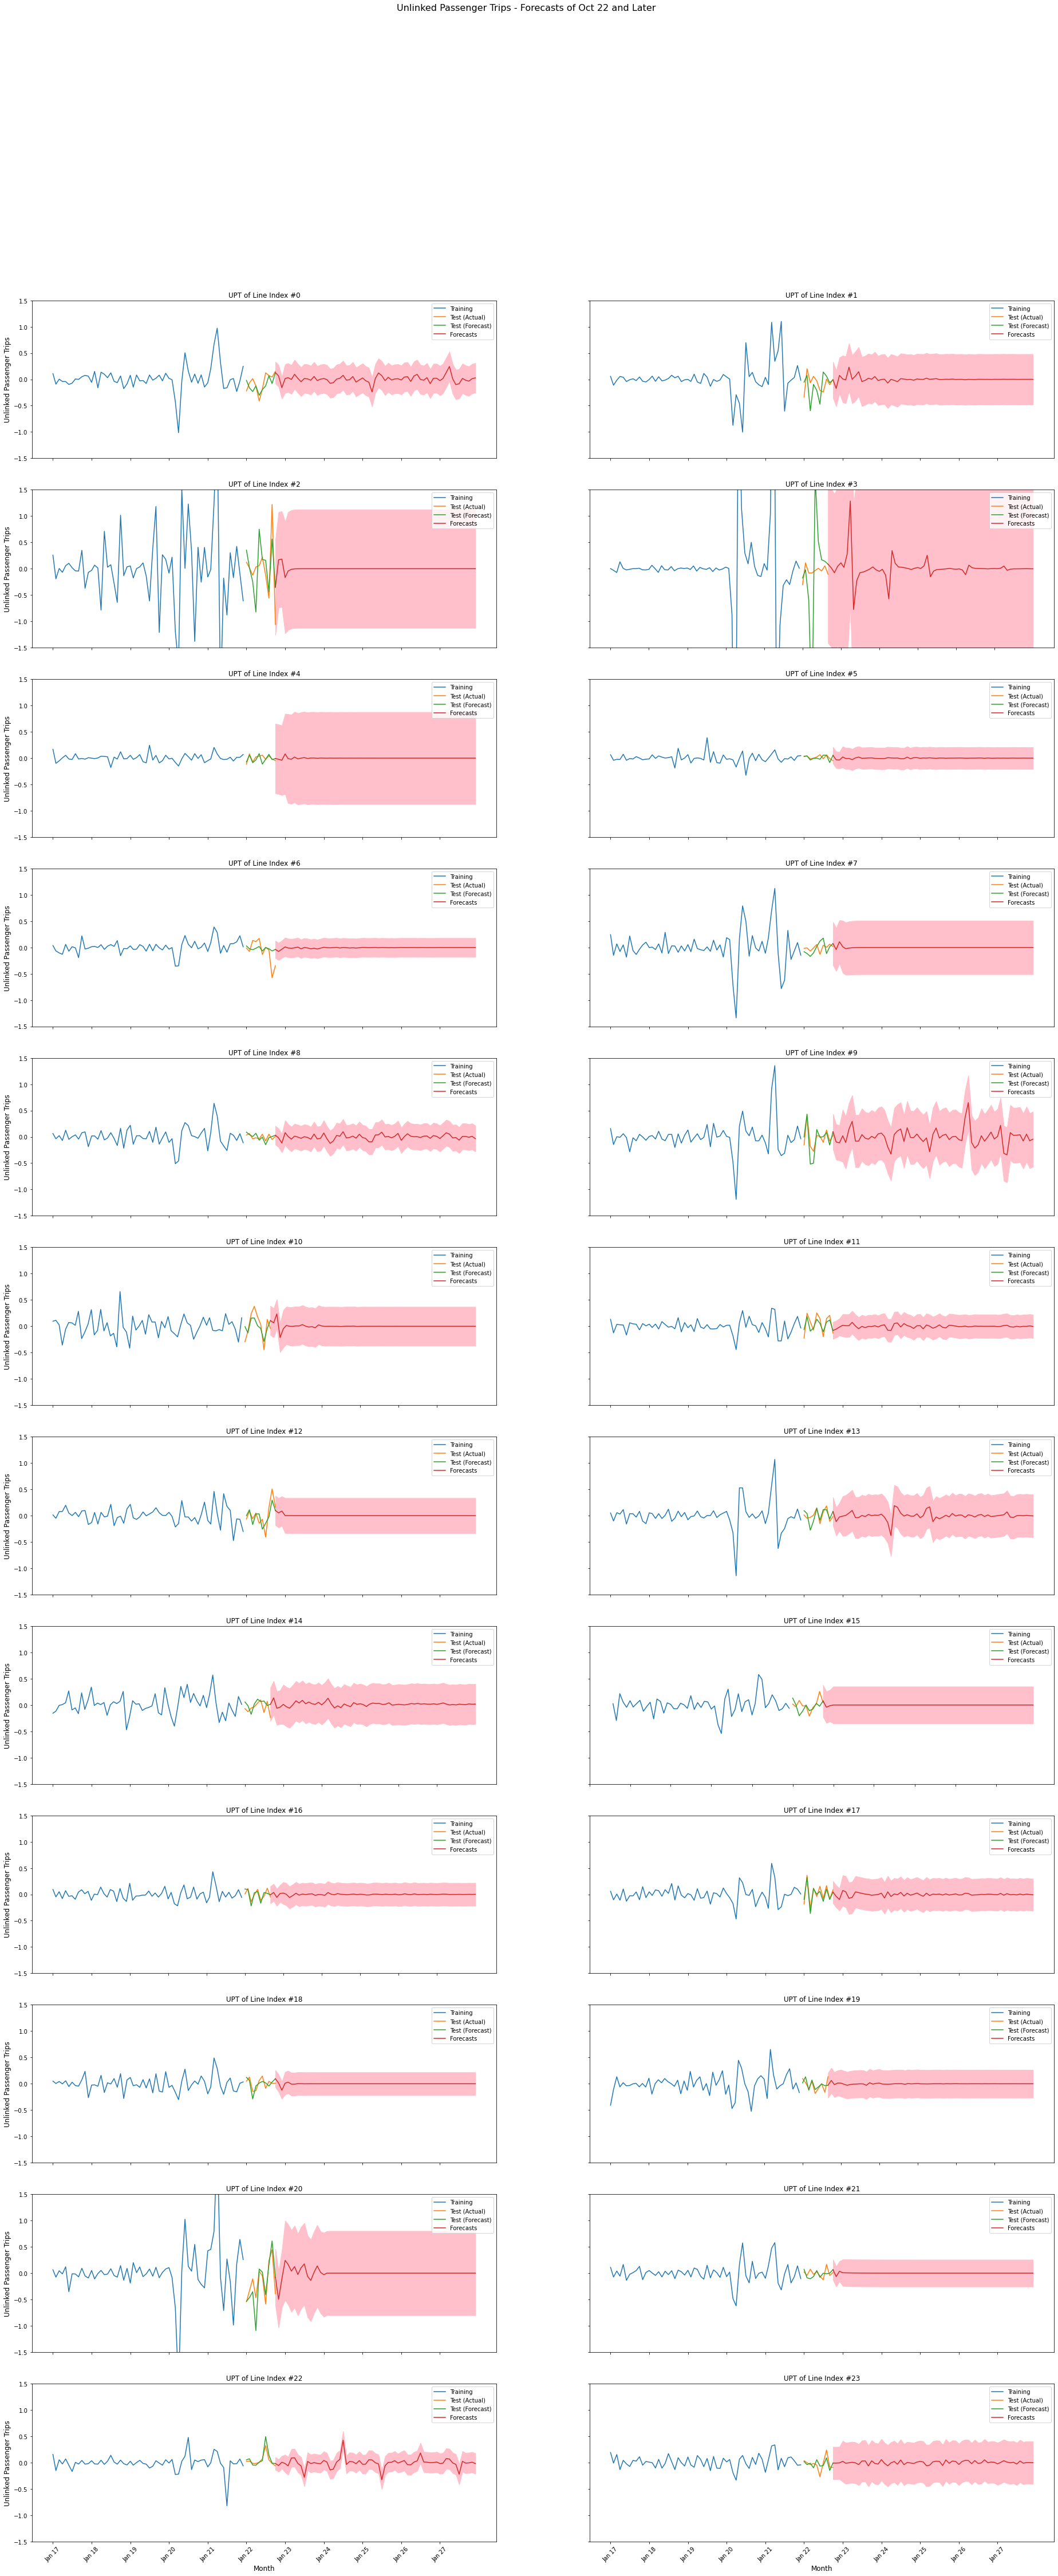

In [425]:
# Add the future forecasts to the previous graphs.

# Most models' forecasted values appear to fizzle out to zero, whether immediately or by the end of the 5-year forecast period.
# This is likely because there is a lack of discernable seasonality in the models' transformed data, so the models' best guesses eventually just become zero.
# Some models, however, were able to make varying non-zero predictions throughout the entire period.
# Either way, each of these models' data have been differenced and many have been taken the log of, so a string of near-flat or near-zero forecasts here doesn't indicate the same patterns within the original data.
# Ranges in confidence intervals vary heavily and don't appear to necessarily be dependent on the predicted values or any variation among them.

fig, axes = plt.subplots(12, 2, figsize = (32, 72), sharey = True)
plt.suptitle('Unlinked Passenger Trips - Forecasts of Oct 22 and Later', fontsize = 16)
ax_count_x = 0
ax_count_y = 0

potential_xticks = ['2017-01-31', '2018-01-31', '2019-01-31', '2020-01-31', '2021-01-31', '2022-01-31', '2023-01-31', '2024-01-31', '2025-01-31', '2026-01-31', '2027-01-31']
potential_xticklabels = ['Jan 17', 'Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22', 'Jan 23', 'Jan 24', 'Jan 25', 'Jan 26', 'Jan 27']
end_of_xticks = math.floor(months_to_predict / 12)

for model in range(len(models_dict)):
    axes[ax_count_x, ax_count_y].plot(TS_std_df_dict_diffs_train[model].loc['2017-01-31':], label = 'Training')
    axes[ax_count_x, ax_count_y].plot(TS_std_df_dict_diffs_test[model], label = 'Test (Actual)')
    axes[ax_count_x, ax_count_y].plot(test_forecasts_dict[model], label = 'Test (Forecast)')
    axes[ax_count_x, ax_count_y].plot(new_forecasts_dict[model], label = 'Forecasts')
    axes[ax_count_x, ax_count_y].fill_between(new_forecasts_CI_dict[model].index, new_forecasts_CI_dict[model]['LB'], new_forecasts_CI_dict[model]['UB'], color = 'pink')

    axes[ax_count_x, ax_count_y].set_title('UPT of Line Index #' + str(model))
    axes[ax_count_x, ax_count_y].set_xlabel('Month', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_ylabel('Unlinked Passenger Trips', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_xticks(potential_xticks[:(6 + end_of_xticks)])
    axes[ax_count_x, ax_count_y].set_xticklabels(potential_xticklabels[:(6 + end_of_xticks)], rotation = 45)
    axes[ax_count_x, ax_count_y].set_ylim([-1.5, 1.5])
    axes[ax_count_x, ax_count_y].label_outer()
    axes[ax_count_x, ax_count_y].legend()

    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 18', color = 'green', ls = '--')   # CONSIDER FIXING LATER: Plotting only y-values (instead of X vs. y) prevents this code from working properly.
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 19', color = 'green', ls = '--')   #                        However, not every date (X-value) has a matching data point (y-value), which is why the dates aren't being explicitly plotted.
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 20', color = 'red', ls = '-')
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 21', color = 'red', ls = '--')
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 22', color = 'red', ls = '--')

    ax_count_y += 1
    if ax_count_y == 2:
        ax_count_x +=1
        ax_count_y = 0

plt.show()

__Objective__: Forecast the absolute UPT for each line.

In [462]:
# For each model, create a dataframe containing a column for each of the transformations, and store them in a dictionary.

TS_final_fc_df_dict = {}

for line in range(len(TS_std_df_dict)):
    fc_df_temp = new_forecasts_dict[line].copy()

    std_df_temp = TS_std_df_dict[line].loc['2015-01-31':].copy()
    std_df_temp = std_df_temp.rename(columns = {'UPT': 'UPT (Standardized)'})

    logs_df_temp = TS_std_df_dict_log[line].loc['2015-01-31':].copy()
    logs_df_temp = logs_df_temp.rename(columns = {'UPT': 'UPT (Logged)'})

    diffs_df_temp = TS_std_df_dict_diffs_mth[line].loc['2015-01-31':].copy()
    diffs_df_temp = diffs_df_temp.rename(columns = {'UPT': 'UPT (Differenced())'})

    diffs12_df_temp = TS_std_df_dict_diffs[line].loc['2015-01-31':].copy()
    diffs12_df_temp = diffs12_df_temp.rename(columns = {'UPT': 'UPT (Differenced(12))'})

    final_fc_df = pd.DataFrame(data = std_df_temp, index = pd.date_range(start = dt.date(2015, 1, 31), freq = 'M', periods = 84 + 10 + months_to_predict))

    final_fc_df = final_fc_df.join(logs_df_temp)
    final_fc_df = final_fc_df.join(diffs_df_temp)
    final_fc_df = final_fc_df.join(diffs12_df_temp)
    final_fc_df = final_fc_df.join(fc_df_temp)
    final_fc_df['UPT (Differenced(12) + Predicted)'] = np.nan
    final_fc_df['UPT (Final)'] = np.nan
    final_fc_df = final_fc_df.resample(rule = 'MS').last()   # Later code will require referencing values a year prior, and without this line it will have trouble referencing prior February 28 vs. February 29.
    
    for d, val in final_fc_df.loc[:'2022-10-01'].iterrows():
        final_fc_df.loc[d, 'UPT (Differenced(12) + Predicted)'] = final_fc_df.loc[d, 'UPT (Differenced(12))']
    for d, val in final_fc_df.loc['2022-11-01':].iterrows():
        final_fc_df.loc[d, 'UPT (Differenced(12) + Predicted)'] = final_fc_df.loc[d, 'UPT (Predicted)']
    if np.isnan(final_fc_df.loc['2022-10-01', 'UPT (Differenced(12) + Predicted)']):
        final_fc_df.loc['2022-10-01', 'UPT (Differenced(12) + Predicted)'] = final_fc_df.loc['2022-10-01', 'UPT (Predicted)']
    
    TS_final_fc_df_dict[line] = final_fc_df

In [463]:
# For each dataframe, back out each transformation to arrive at the standardized but otherwise untransformed data.

for line in range(len(TS_final_fc_df_dict)):
    for d, val in TS_final_fc_df_dict[line].loc['2017-01-01':].iterrows():
        
        # Back out the diff(12) transformation, leaving the diff() and log transformations.

        years_diff = d.year - 2016
        years_count = 0
        temp_answer = TS_final_fc_df_dict[line].loc[d - pd.DateOffset(years = years_diff), 'UPT (Differenced())']
        while years_count < years_diff:
            temp_answer += TS_final_fc_df_dict[line].loc[d - pd.DateOffset(years = years_count), 'UPT (Differenced(12) + Predicted)']
            years_count += 1
        TS_final_fc_df_dict[line].loc[d, 'UPT (Final)'] = temp_answer
        TS_final_fc_df_dict[line].loc[d, 'temp'] = temp_answer

        # Back out the diff() transformation, leaving the log transformation.

        temp_answer = TS_final_fc_df_dict[line].loc['2016-12-01', 'UPT (Logged)']
        temp_answer += np.array(TS_final_fc_df_dict[line].loc['2017-01-01' : d, 'temp']).cumsum()[-1]
        TS_final_fc_df_dict[line].loc[d, 'UPT (Final)'] = temp_answer


        # Back out the log transformation, leaving the standardized original data.

        if line in ADF_min_list_log:
            temp_answer = np.exp(TS_final_fc_df_dict[line].loc[d, 'UPT (Final)'])
            TS_final_fc_df_dict[line].loc[d, 'UPT (Final)'] = temp_answer

    TS_final_fc_df_dict[line] = TS_final_fc_df_dict[line].drop(columns = ['temp'])
    TS_final_fc_df_dict[line] = TS_final_fc_df_dict[line].resample(rule = 'M').last()

In [465]:
# Finally, multiply each dataframe by its original maximum UPT to arrive at the line's absolute UPT, cut it off before Jan 2017, and split it into its historical and predicted values.

TS_final_fc_df_dict_hist = {}
TS_final_fc_df_dict_pred = {}

for line in range(len(TS_final_fc_df_dict)):
    TS_final_fc_df_dict[line] = pd.DataFrame(TS_final_fc_df_dict[line]['UPT (Final)'].loc['2017-01-31':]) * max_dict[line]
    TS_final_fc_df_dict_hist[line] = TS_final_fc_df_dict[line].loc[:'2022-10-31']
    TS_final_fc_df_dict_pred[line] = TS_final_fc_df_dict[line].loc['2022-10-31':]

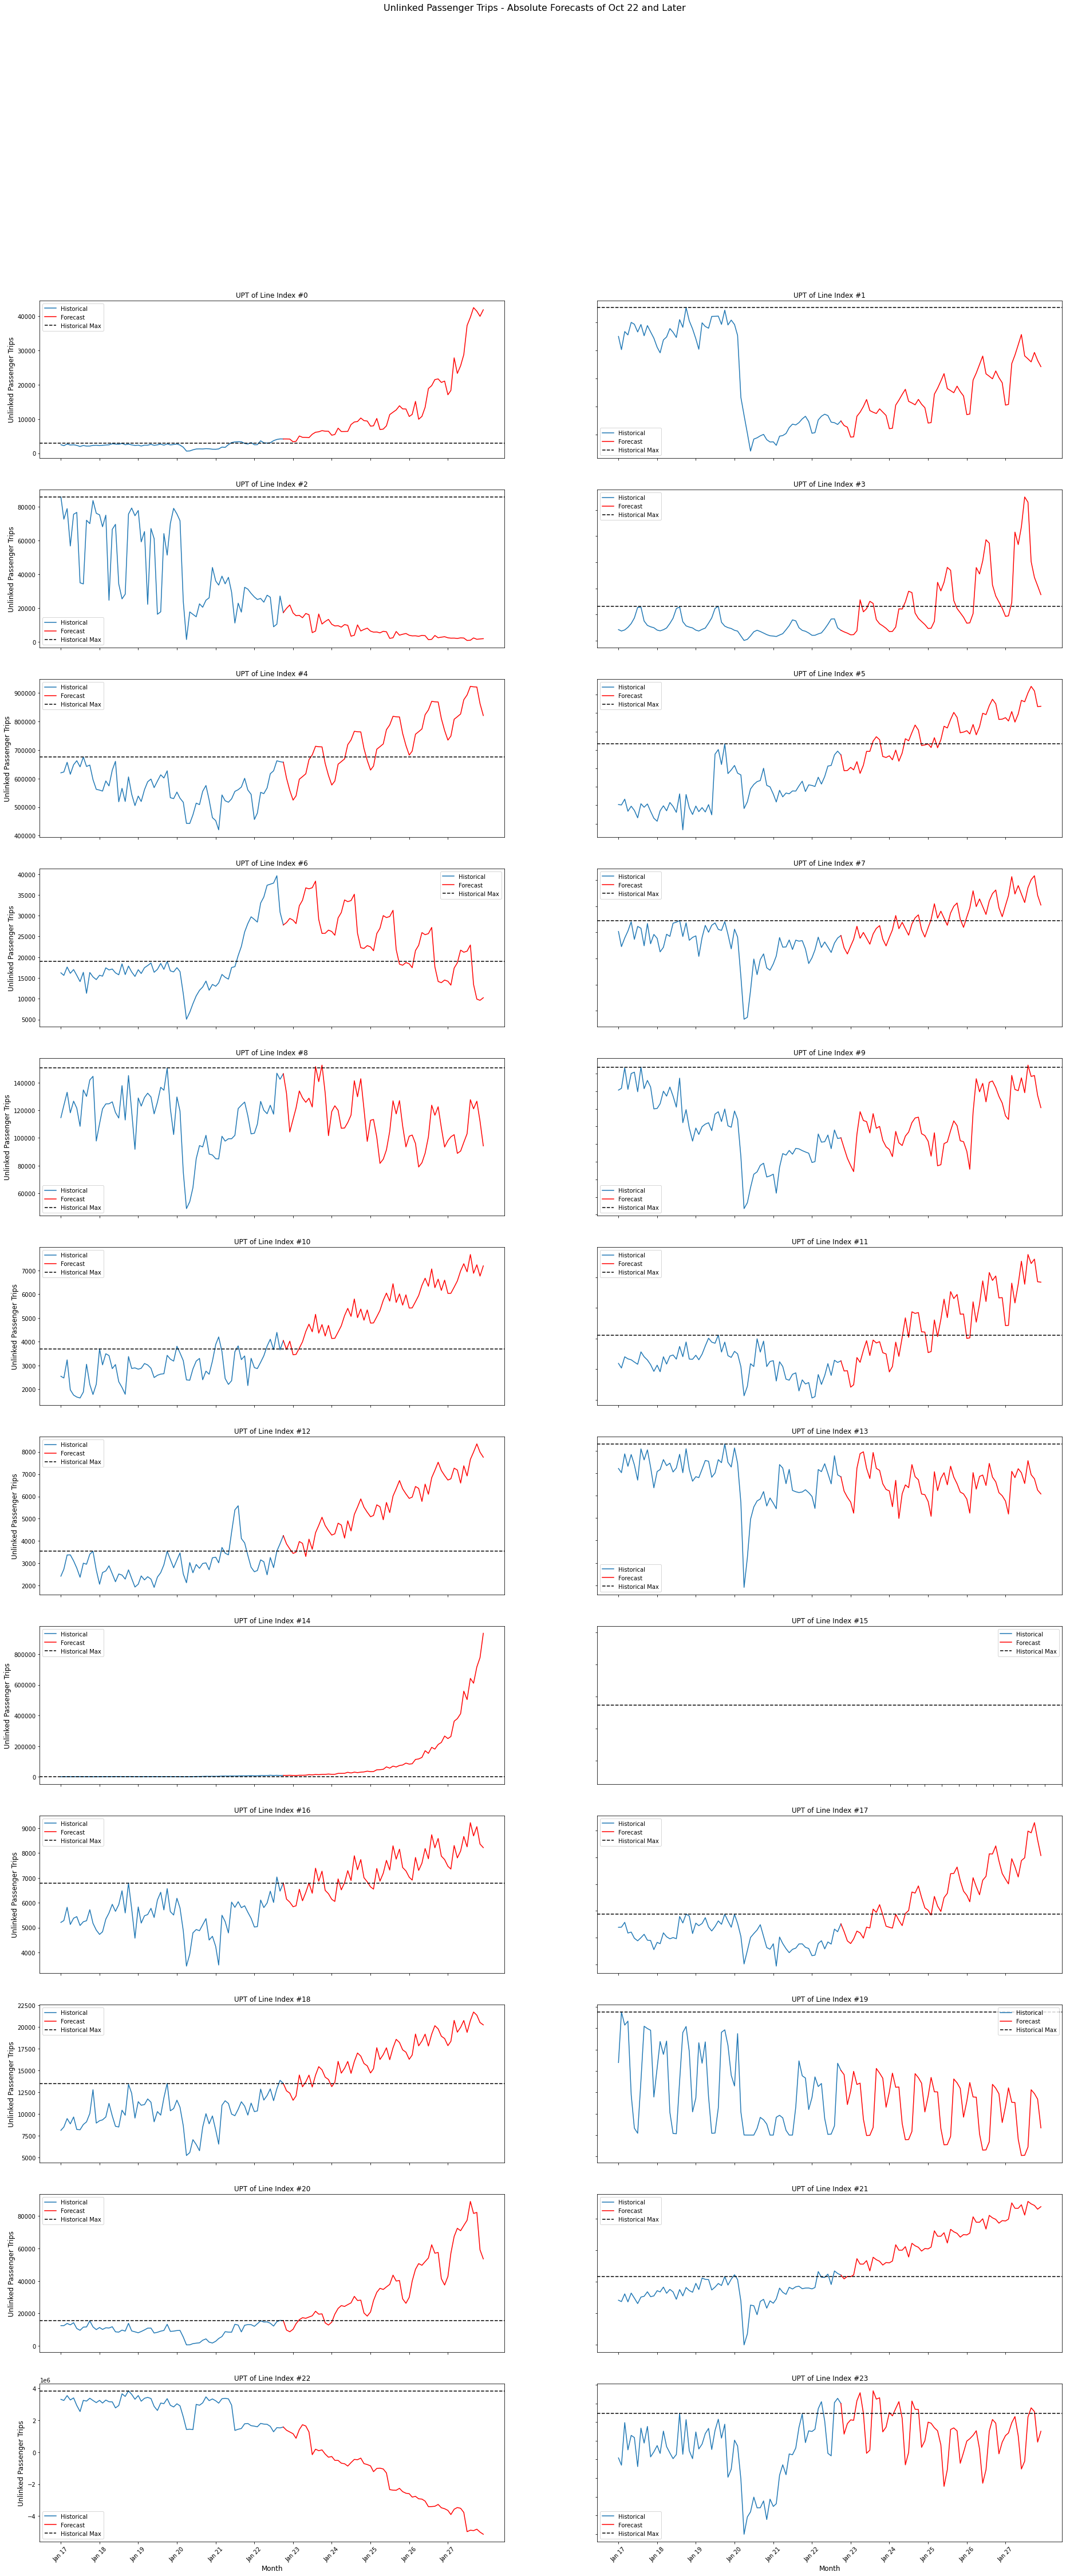

In [476]:
# Graph the absolute future forecasts.

# Each model's forecasts distinctly reflect the exponential, monthly, or seasonal patterns that it was transformed from during the analysis.
# They generally reflect the post-COVID patterns more than the pre-COVID patterns. This could make sense given that COVID was a very large and recent shock to the data.
# As a result, most lines whose UPT was trending upward post-COVID are predicted to trend upward and surpass their previous recent historical UPT maximum,
# and most lines whose UPT was trending downward post-COVID continue to trend downward.

# Noteworthy patterns:
# - Line index #0 apparently improved its UPT so much post-COVID that it is projected by the end of the period to increase its UPT by over 10 times, to approximately 42,000.
#   Given that its current service area population is ~60,000, this seems more likely to level off at some point beforehand, unless the area also experiences some population boom.
# - Line index #14, similarly, only improved its UPT between pre-COVID and post-COVID times, such that it is projected by the end of the period to increase its UPT to ~900,000 from its current historical max of ~12,000.
# - As a direct response line opened within the last 10 years to a current service area population of ~200,000, it is likely still picking up steam rather than experiencing skyrocketing exponential growth.
# - Line index #15 was opened so recently that it did not have enough historical data to be untransformed via the cumulative summing for-loop in the previous few coding sections.
#   Consider returning to this code and giving it its own exception to make it work.
# - Line index #22, conversely to #0 and #14, is on such a post-COVID downturn that it is ultimately projected to decrease its UPT from its historical max of ~4,000,000 to nearly -5,000,000.
#   More likely it will level off, potentially close to or at 0 if service is truly winding down to closure.

fig, axes = plt.subplots(12, 2, figsize = (32, 72))
plt.suptitle('Unlinked Passenger Trips - Absolute Forecasts of Oct 22 and Later', fontsize = 16)
ax_count_x = 0
ax_count_y = 0

potential_xticks = ['2017-01-31', '2018-01-31', '2019-01-31', '2020-01-31', '2021-01-31', '2022-01-31', '2023-01-31', '2024-01-31', '2025-01-31', '2026-01-31', '2027-01-31']
potential_xticklabels = ['Jan 17', 'Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22', 'Jan 23', 'Jan 24', 'Jan 25', 'Jan 26', 'Jan 27']
end_of_xticks = math.floor(months_to_predict / 12)

for model in range(len(TS_final_fc_df_dict)):
    axes[ax_count_x, ax_count_y].plot(TS_final_fc_df_dict_hist[model], label = 'Historical')
    axes[ax_count_x, ax_count_y].plot(TS_final_fc_df_dict_pred[model], label = 'Forecast', color = 'red')
    axes[ax_count_x, ax_count_y].axhline(y = max_dict[model], label = 'Historical Max', color = 'black', ls = '--')

    axes[ax_count_x, ax_count_y].set_title('UPT of Line Index #' + str(model))
    axes[ax_count_x, ax_count_y].set_xlabel('Month', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_ylabel('Unlinked Passenger Trips', fontsize = 12)
    axes[ax_count_x, ax_count_y].set_xticks(potential_xticks[:(6 + end_of_xticks)])
    axes[ax_count_x, ax_count_y].set_xticklabels(potential_xticklabels[:(6 + end_of_xticks)], rotation = 45)
    axes[ax_count_x, ax_count_y].label_outer()
    axes[ax_count_x, ax_count_y].legend()

    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 18', color = 'green', ls = '--')   # CONSIDER FIXING LATER: Plotting only y-values (instead of X vs. y) prevents this code from working properly.
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 19', color = 'green', ls = '--')   #                        However, not every date (X-value) has a matching data point (y-value), which is why the dates aren't being explicitly plotted.
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 20', color = 'red', ls = '-')
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 21', color = 'red', ls = '--')
    #axes[ax_count_x, ax_count_y].axvline(x = 'Jan 22', color = 'red', ls = '--')

    ax_count_y += 1
    if ax_count_y == 2:
        ax_count_x +=1
        ax_count_y = 0

plt.show()